In [1]:
import pandas as pd
import plotly.express as px
import seaborn as sns
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os
import sys
import dask as dd
from dask import dataframe
sys.path.insert(0, "C:/workspace/data-science//libs")

from monte_carlo import CauchyGenerator, PoissonGenerator, NormalGenerator, ParetoGenerator, LognormalGenerator, Transaction,\
                        MonteCarloTransactionSimulator, CauchyParameterSearcher, LognormalParameterSearcher
from uniswap_v2_tools import show_swaps_count_moving_averages, show_reserves_time_distribution, show_reserve_price_distributions,\
                                show_swaps_amount_in_moving_averages, calc_price_and_increase_rates, increase_rate_moving_averages,\
                                    swaps_price_change_rates_moving_averages, pyplot_line_swap_change_rate, pyplot_line_swap_prices,\
                                        get_df_with_swap_prices_and_change_rates

In [2]:
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

# DOG/WETH

In [3]:
dog_weth_df = pd.read_pickle(os.getcwd() + '\\pkl_stories\\dog_weth_swaps.pkl')
dog_weth_mints_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\dog_weth_mints.pkl")
dog_weth_burns_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\dog_weth_burns.pkl")
dog_weth_reserves_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\dog_weth_reserves.pkl")

In [4]:
print((dog_weth_df.timestamp[0] - dog_weth_df.timestamp[len(dog_weth_df) - 1]).days)

-103


C:\Users\Zbook\anaconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


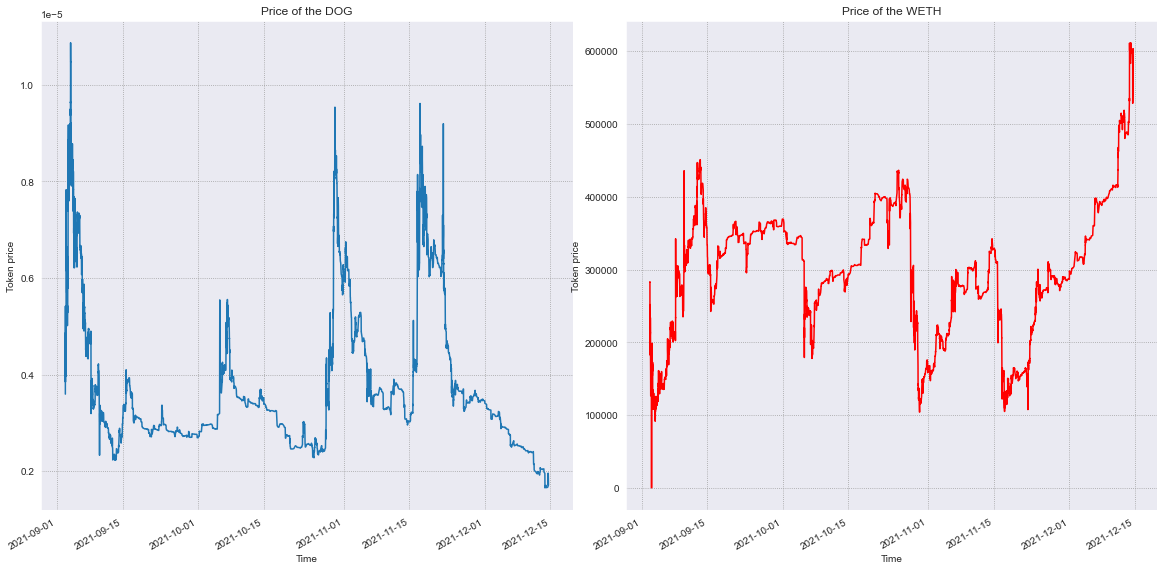

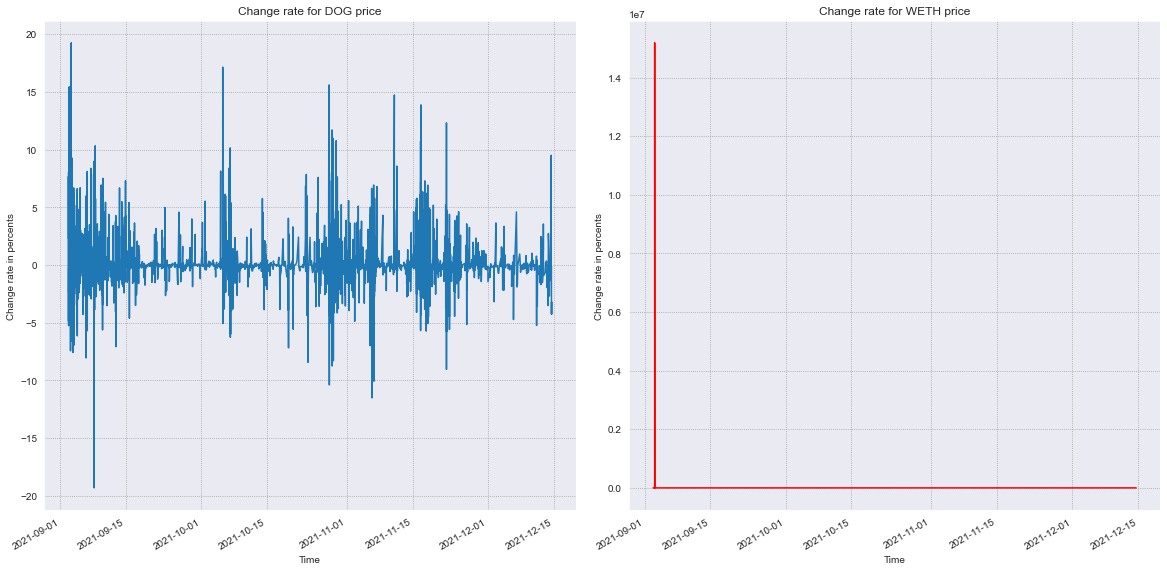

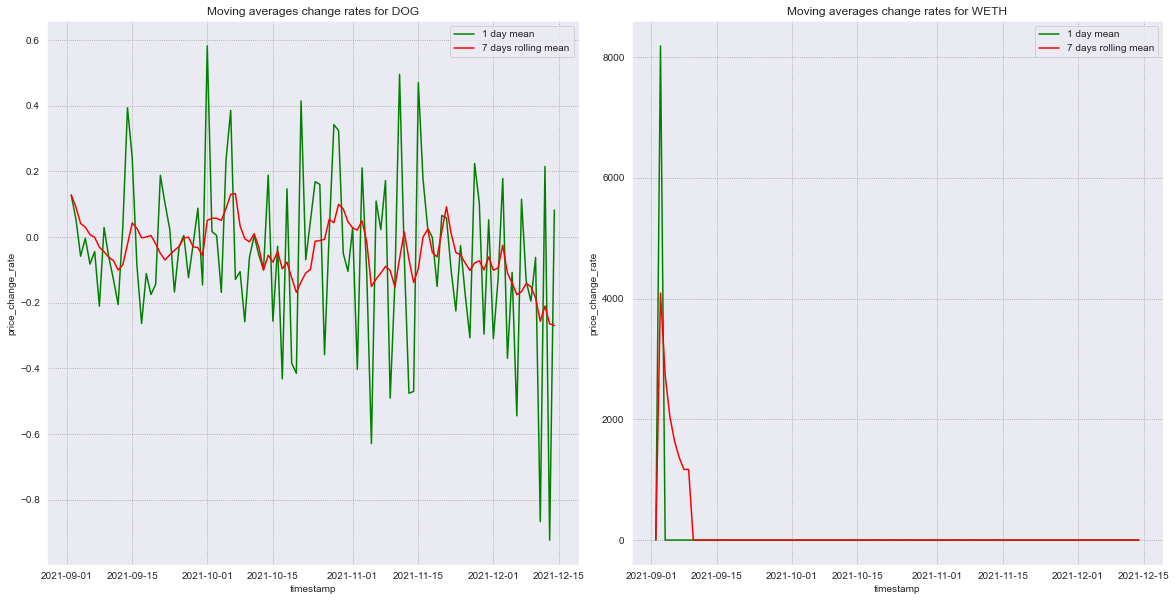

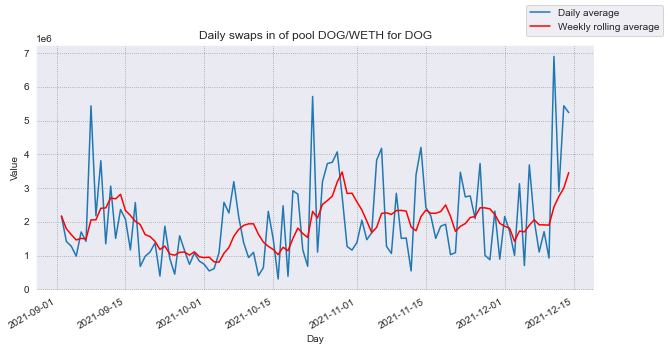

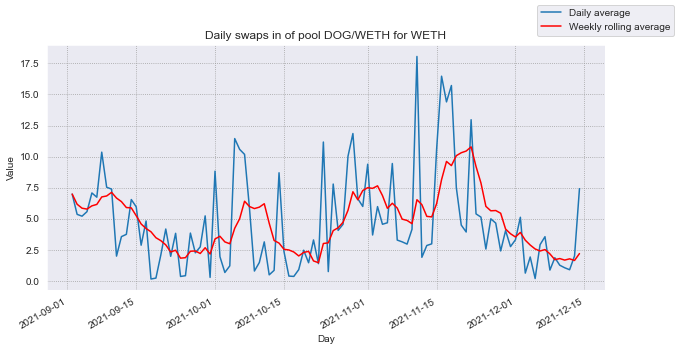

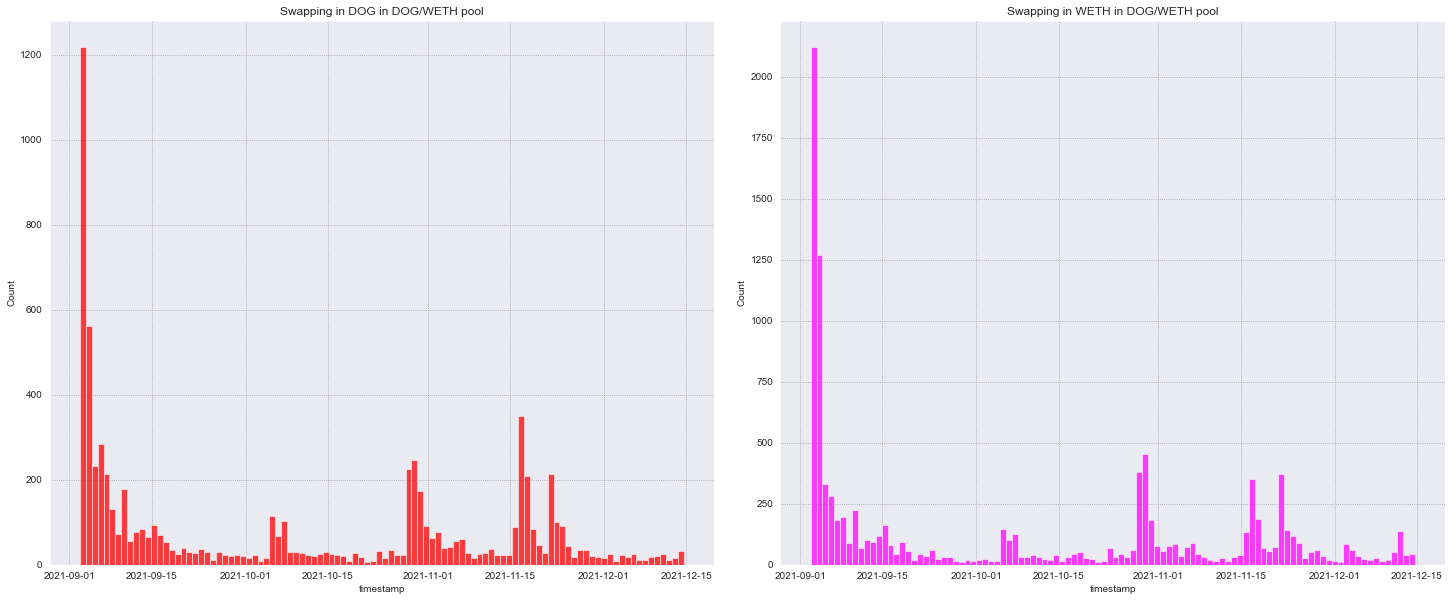

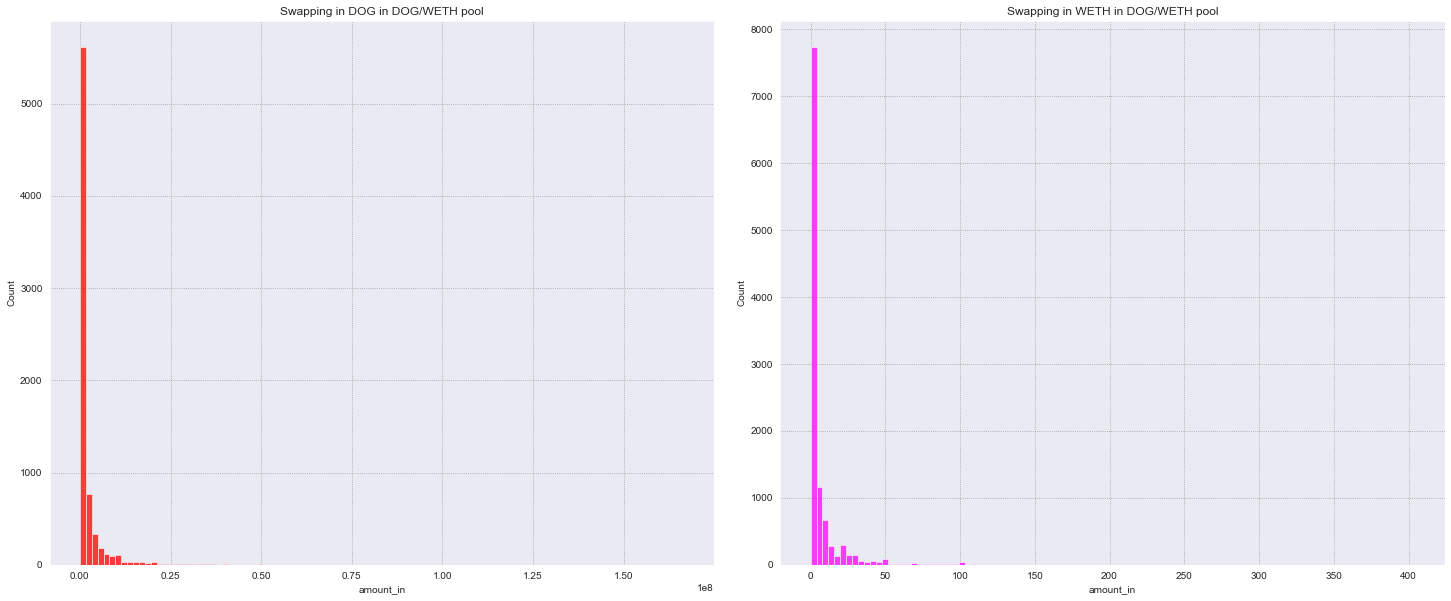

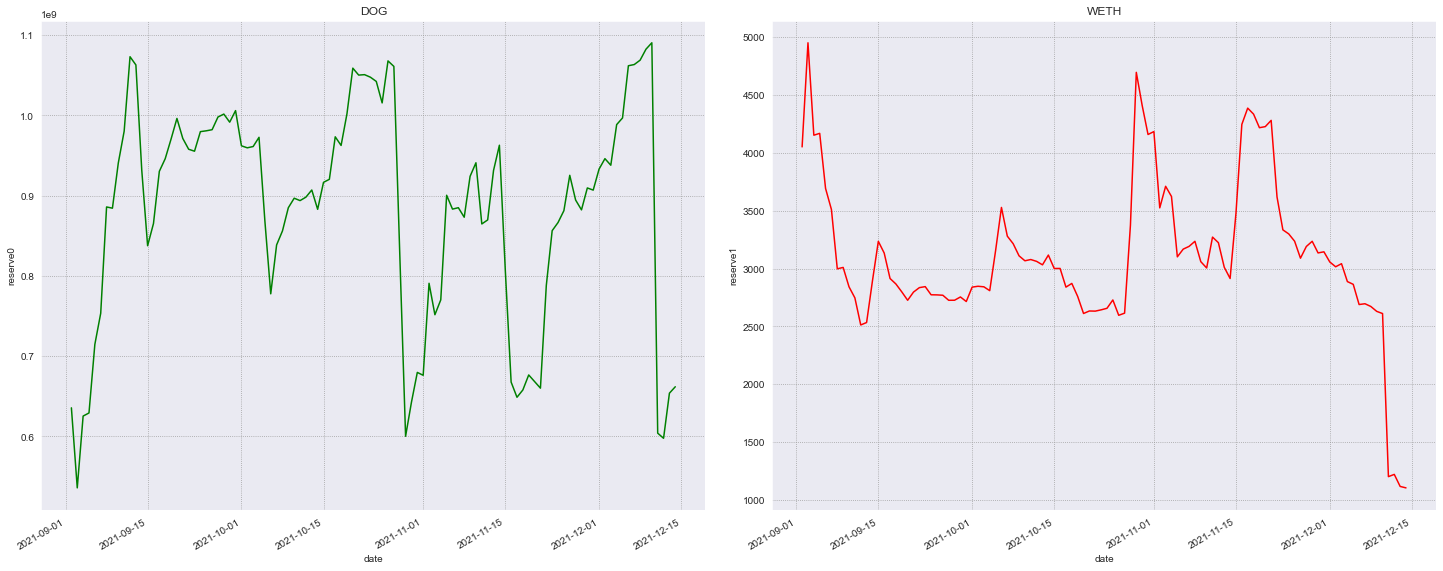

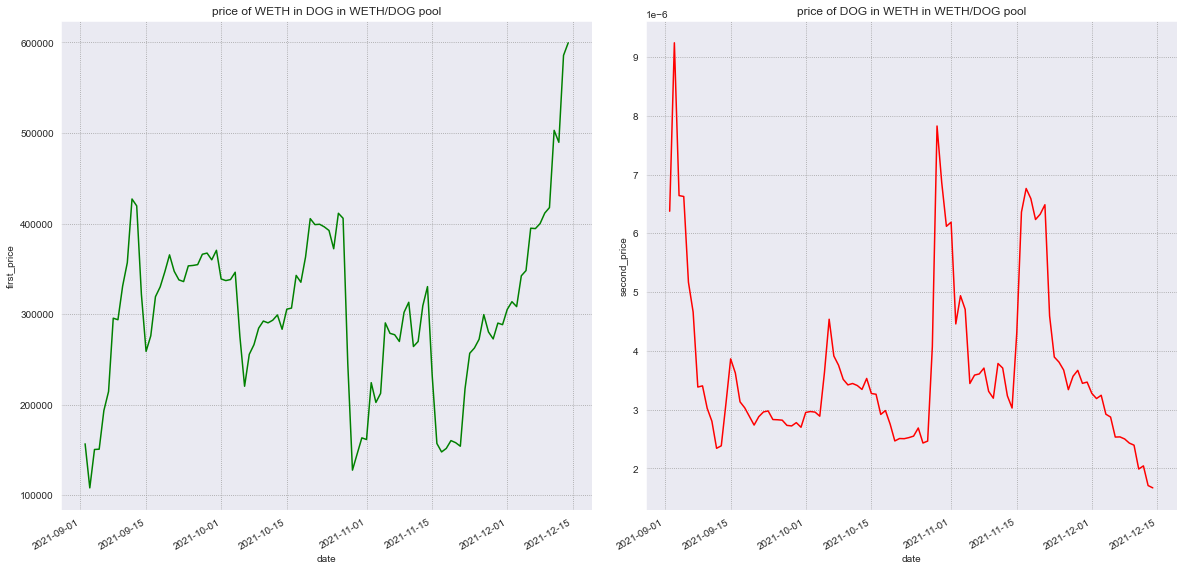

In [6]:
dog_weth_df = get_df_with_swap_prices_and_change_rates(dog_weth_df, 'DOG', 'WETH')

pyplot_line_swap_prices(dog_weth_df, 'DOG', 'WETH', xsize=20, ysize=10, wspace=0.1, hspace=0.1)

pyplot_line_swap_change_rate(dog_weth_df, 'DOG', 'WETH', xsize=20, ysize=10, wspace=0.1, hspace=0.1)

swaps_price_change_rates_moving_averages(dog_weth_df, 'DOG', 'WETH', 'Moving averages change rates for DOG',
                                           'Moving averages change rates for WETH', x_size=20, y_size=10, 
                                           wspace=0.1, hspace=0.1)

show_swaps_amount_in_moving_averages(swaps_df=dog_weth_df[(dog_weth_df.token_in == 'DOG')], 
                                     pool_name="DOG/WETH for DOG")
show_swaps_amount_in_moving_averages(swaps_df=dog_weth_df[(dog_weth_df.token_in == 'WETH')], 
                                     pool_name="DOG/WETH for WETH")

# swapping values histograms
plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
sns.histplot(data=dog_weth_df[dog_weth_df.token_in == 'DOG'], 
             x='timestamp', bins=(dog_weth_df.timestamp[len(dog_weth_df) - 1] - dog_weth_df.timestamp[0]).days, 
             color='red').set_title("Swapping in DOG in DOG/WETH pool")
plt.subplot(1, 2, 2)
sns.histplot(data=dog_weth_df[dog_weth_df.token_in == 'WETH'], 
             x='timestamp', bins=(dog_weth_df.timestamp[len(dog_weth_df) - 1] - dog_weth_df.timestamp[0]).days, 
             color='magenta').set_title("Swapping in WETH in DOG/WETH pool")
plt.subplots_adjust(wspace=0.1)
plt.show()

# swapping in values distribution
plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
sns.histplot(data=dog_weth_df[dog_weth_df.token_in == 'DOG'], 
             x='amount_in', bins=(dog_weth_df.timestamp[len(dog_weth_df) - 1] - dog_weth_df.timestamp[0]).days, 
             color='red').set_title("Swapping in DOG in DOG/WETH pool")
plt.subplot(1, 2, 2)
sns.histplot(data=dog_weth_df[dog_weth_df.token_in == 'WETH'], 
             x='amount_in', bins=(dog_weth_df.timestamp[len(dog_weth_df) - 1] - dog_weth_df.timestamp[0]).days, 
             color='magenta').set_title("Swapping in WETH in DOG/WETH pool")
plt.subplots_adjust(wspace=0.1)
plt.show()

show_reserves_time_distribution(dog_weth_reserves_df, first_token_reserve_name="DOG", 
                                           second_token_reserve_name="WETH", x=25, y=10, wspace=0.1)

show_reserve_price_distributions(dog_weth_reserves_df, 
                                        first_token_price_name="price of WETH in DOG in WETH/DOG pool", 
                                        second_token_price_name="price of DOG in WETH in WETH/DOG pool", 
                                        x=20, y=10, wspace=0.1)

In [7]:
dog_weth_df[dog_weth_df.price_change_rate > 300]

token_in token_out  amount_in     amount_out   amount_usd  \
1795     WETH       DOG   0.732161  111197.902644  2762.330111   

               timestamp                                      sender  \
1795 2021-09-03 03:18:14  0x724430950c98a3d67540e9cfa8be0809f4833e13   

                                              to  \
1795  0x7731ca4d00800b6a681d031f565deb355c5b77da   

                                                    txd  \
1795  0xa45cee771972f21818393ffa2111df891ad9110d24f8...   

      first_to_second_price  price_change_rate  
1795           151876.27483       1.518753e+07

In [8]:
dog_weth_df[(dog_weth_df.index > 1780) & (dog_weth_df.index < 1800)][
    ['token_in', 'token_out', 'amount_in', 'amount_out', 'amount_usd', 'timestamp', 
     'first_to_second_price', 'price_change_rate']
]

token_in token_out     amount_in    amount_out    amount_usd  \
1781     WETH       DOG  1.515658e-02  2.305236e+03  5.705727e+01   
1782     WETH       DOG  1.000000e+00  1.521270e+05  3.768735e+03   
1783      DOG      WETH  5.115499e+04  3.343045e-01  1.259905e+03   
1784     WETH       DOG  6.100306e-01  9.278098e+04  2.298992e+03   
1785     WETH       DOG  7.000000e-02  1.064403e+04  2.638056e+02   
1786     WETH       DOG  1.321200e-01  2.009082e+04  4.979142e+02   
1787     WETH       DOG  2.000000e-01  3.040804e+04  7.537302e+02   
1788     WETH       DOG  1.000000e-01  1.520512e+04  3.768651e+02   
1789     WETH       DOG  5.000000e-01  7.599984e+04  1.884342e+03   
1790     WETH       DOG  1.000000e-01  1.519776e+04  3.768683e+02   
1791     WETH       DOG  2.000000e-01  3.040509e+04  7.537366e+02   
1792     WETH       DOG  3.469375e-02  5.272499e+03  1.308105e+02   
1793     WETH       DOG  9.256591e-01  1.406421e+05  3.490815e+03   
1794     WETH       DOG  1.000000e-18  1.000000e-18  3.772845e-15   
1795     WETH       DOG  7.321611e-01  1.111979e+05  2.762330e+03   
1796      DOG      WETH  8.525832e+04  5.580274e-01  2.105383e+03   
1797      DOG      WETH  6.832238e+04  4.470701e-01  1.686752e+03   
1798     WETH       DOG  5.000000e-02  7.651800e+03  1.886451e+02   
1799      DOG      WETH  2.456156e+06  1.600779e+01  6.039583e+04   

               timestamp  first_to_second_price  price_change_rate  
1781 2021-09-03 03:08:26          152094.688665      -4.396761e-04  
1782 2021-09-03 03:09:52          152127.004367       2.124709e-02  
1783 2021-09-03 03:09:52               0.000007       1.742710e-02  
1784 2021-09-03 03:11:03          152092.342022      -2.278514e-02  
1785 2021-09-03 03:11:34          152057.504671      -2.290539e-02  
1786 2021-09-03 03:11:34          152064.957449       4.901289e-03  
1787 2021-09-03 03:12:26          152040.191800      -1.628623e-02  
1788 2021-09-03 03:12:26          152051.241268       7.267465e-03  
1789 2021-09-03 03:12:47          151999.683923      -3.390787e-02  
1790 2021-09-03 03:12:47          151977.563573      -1.455289e-02  
1791 2021-09-03 03:12:47          152025.453581       3.151124e-02  
1792 2021-09-03 03:14:06          151972.599905      -3.476633e-02  
1793 2021-09-03 03:16:15          151937.293557      -2.323205e-02  
1794 2021-09-03 03:17:31               1.000000      -9.999934e+01  
1795 2021-09-03 03:18:14          151876.274830       1.518753e+07  
1796 2021-09-03 03:18:37               0.000007       1.531304e-01  
1797 2021-09-03 03:19:46               0.000007      -2.442136e-02  
1798 2021-09-03 03:20:48          153036.004588       7.636017e-01  
1799 2021-09-03 03:20:48               0.000007      -3.992318e-01

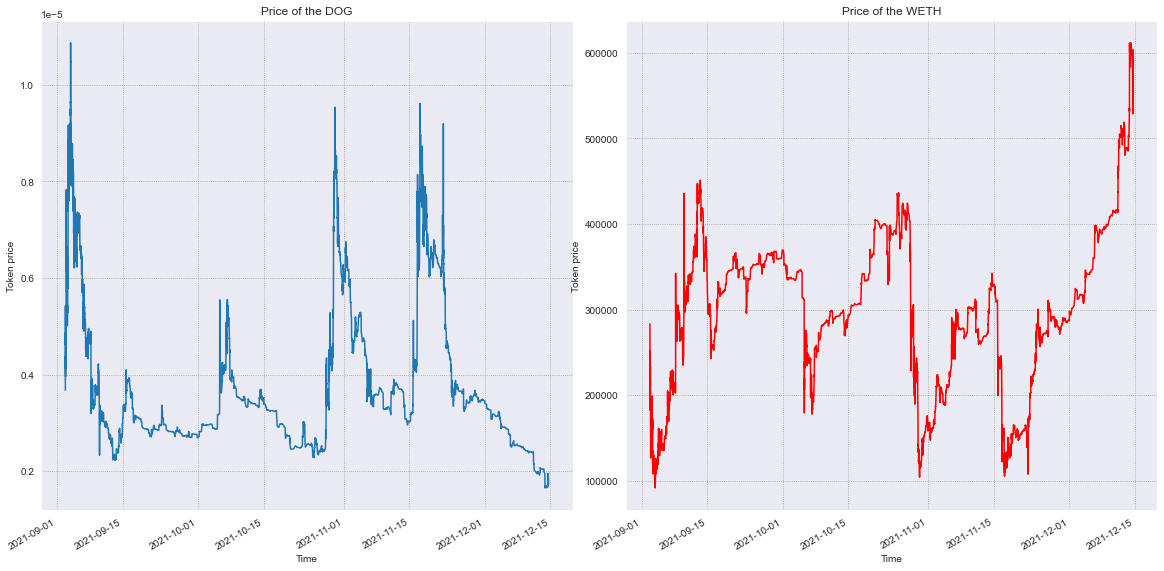

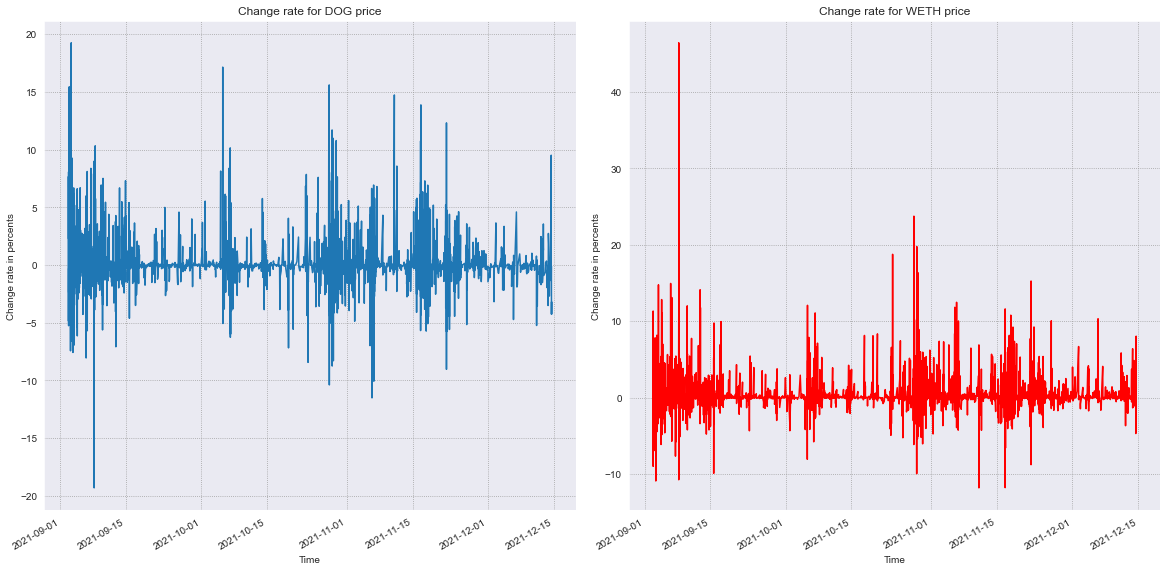

In [9]:
pyplot_line_swap_prices(dog_weth_df[(dog_weth_df.price_change_rate > -99) & (dog_weth_df.price_change_rate < 10000)], 'DOG', 'WETH', xsize=20, ysize=10, wspace=0.1, hspace=0.1)
pyplot_line_swap_change_rate(dog_weth_df[(dog_weth_df.price_change_rate > -99) & (dog_weth_df.price_change_rate < 10000)], 'DOG', 'WETH', xsize=20, ysize=10, wspace=0.1, hspace=0.1)

In [10]:
dog_weth_df[dog_weth_df.price_change_rate > 40]

token_in token_out  amount_in    amount_out    amount_usd  \
1795     WETH       DOG   0.732161  1.111979e+05   2762.330111   
6766     WETH       DOG   4.475955  1.532169e+06  15308.475616   

               timestamp                                      sender  \
1795 2021-09-03 03:18:14  0x724430950c98a3d67540e9cfa8be0809f4833e13   
6766 2021-09-08 06:12:46  0x7777777580290cede6e2121b846023fa1a1e4978   

                                              to  \
1795  0x7731ca4d00800b6a681d031f565deb355c5b77da   
6766  0x7777777580290cede6e2121b846023fa1a1e4978   

                                                    txd  \
1795  0xa45cee771972f21818393ffa2111df891ad9110d24f8...   
6766  0xc8765c5c254dd8550326a6710f2a4af8bb80c9380353...   

      first_to_second_price  price_change_rate  
1795          151876.274830       1.518753e+07  
6766          342311.182285       4.646393e+01

In [11]:
dog_weth_df[(dog_weth_df.index < 6780) & (dog_weth_df.index > 6760)][
    ['token_in', 'token_out', 'amount_in', 'amount_out', 'amount_usd', 'timestamp', 
     'first_to_second_price', 'price_change_rate']
]

token_in token_out     amount_in    amount_out    amount_usd  \
6761      DOG      WETH  4.000000e+05  1.786680e+00  6.146717e+03   
6762      DOG      WETH  1.963133e+07  8.546569e+01  2.925954e+05   
6763     WETH       DOG  3.127514e+00  7.316365e+05  1.069176e+04   
6764     WETH       DOG  1.000000e-02  2.337171e+03  3.420157e+01   
6765      DOG      WETH  1.666000e+08  5.851606e+02  2.001342e+06   
6766     WETH       DOG  4.475955e+00  1.532169e+06  1.530848e+04   
6767     WETH       DOG  3.048794e+00  1.040817e+06  1.042761e+04   
6768     WETH       DOG  3.009913e+02  9.264927e+07  1.029463e+06   
6769     WETH       DOG  3.507867e+01  9.634371e+06  1.199776e+05   
6770      DOG      WETH  9.264927e+07  3.058663e+02  1.046137e+06   
6771     WETH       DOG  9.800000e+01  3.153016e+07  3.347585e+05   
6772     WETH       DOG  4.394560e+00  1.465216e+06  1.501139e+04   
6773      DOG      WETH  1.465216e+06  4.676767e+00  1.597538e+04   
6774     WETH       DOG  7.363900e+00  2.291177e+06  2.515561e+04   
6775     WETH       DOG  4.000000e+01  1.224665e+07  1.366429e+05   
6776      DOG      WETH  2.291177e+06  7.521412e+00  2.569368e+04   
6777     WETH       DOG  2.950138e+01  8.867324e+06  1.002972e+05   
6778      DOG      WETH  5.434034e+05  1.862864e+00  6.329561e+03   
6779     WETH       DOG  4.000000e+01  1.174667e+07  1.359103e+05   

               timestamp  first_to_second_price  price_change_rate  
6761 2021-09-08 05:48:19               0.000004          -0.079932  
6762 2021-09-08 06:09:47               0.000004          -2.533521  
6763 2021-09-08 06:09:47          233935.495474          10.491334  
6764 2021-09-08 06:10:56          233717.052961          -0.093377  
6765 2021-09-08 06:12:46               0.000004         -19.321477  
6766 2021-09-08 06:12:46          342311.182285          46.463931  
6767 2021-09-08 06:12:51          341386.546107          -0.270116  
6768 2021-09-08 06:13:03          307813.722305          -9.834255  
6769 2021-09-08 06:13:03          274650.363959         -10.773840  
6770 2021-09-08 06:13:03               0.000003          -6.008273  
6771 2021-09-08 06:13:26          321736.347021          17.143973  
6772 2021-09-08 06:13:26          333415.784604           3.630127  
6773 2021-09-08 06:13:26               0.000003          -3.316036  
6774 2021-09-08 06:13:51          311136.404660          -6.682161  
6775 2021-09-08 06:13:51          306166.293547          -1.597406  
6776 2021-09-08 06:13:51               0.000003           2.848163  
6777 2021-09-08 06:14:47          300573.243389          -1.826801  
6778 2021-09-08 06:15:27               0.000003           4.428298  
6779 2021-09-08 06:15:27          293666.783904          -2.297763

# NFD/WETH

In [12]:
nfd_weth_df = pd.read_pickle(os.getcwd() + '\\pkl_stories\\nfd_weth_swaps.pkl')
nfd_weth_mints_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\nfd_weth_mints.pkl")
nfd_weth_burns_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\nfd_weth_burns.pkl")
nfd_weth_reserves_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\nfd_weth_reserves.pkl")

C:\Users\Zbook\anaconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


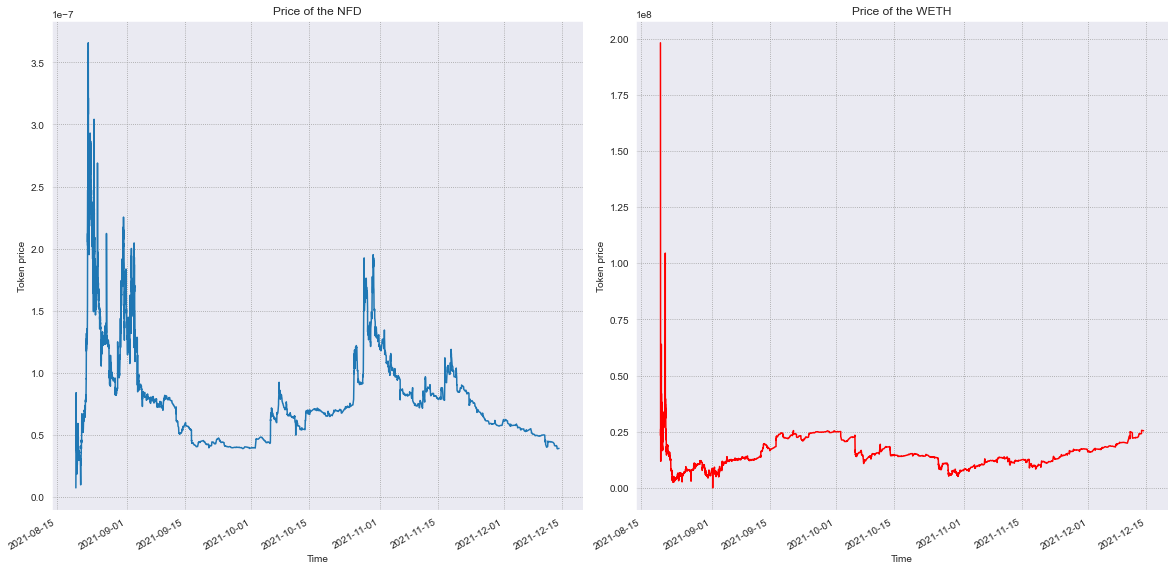

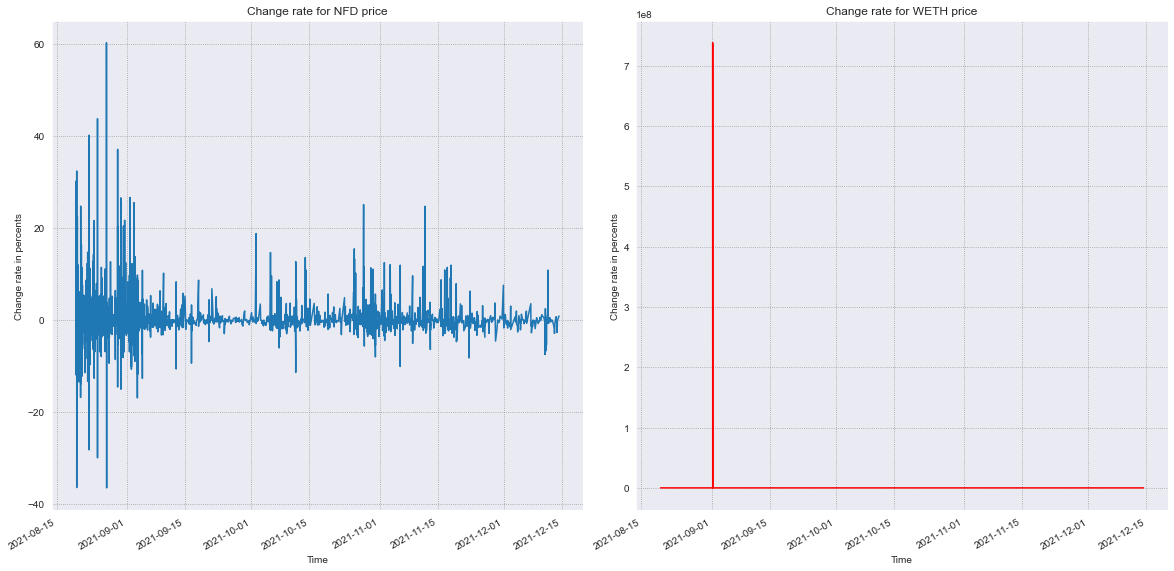

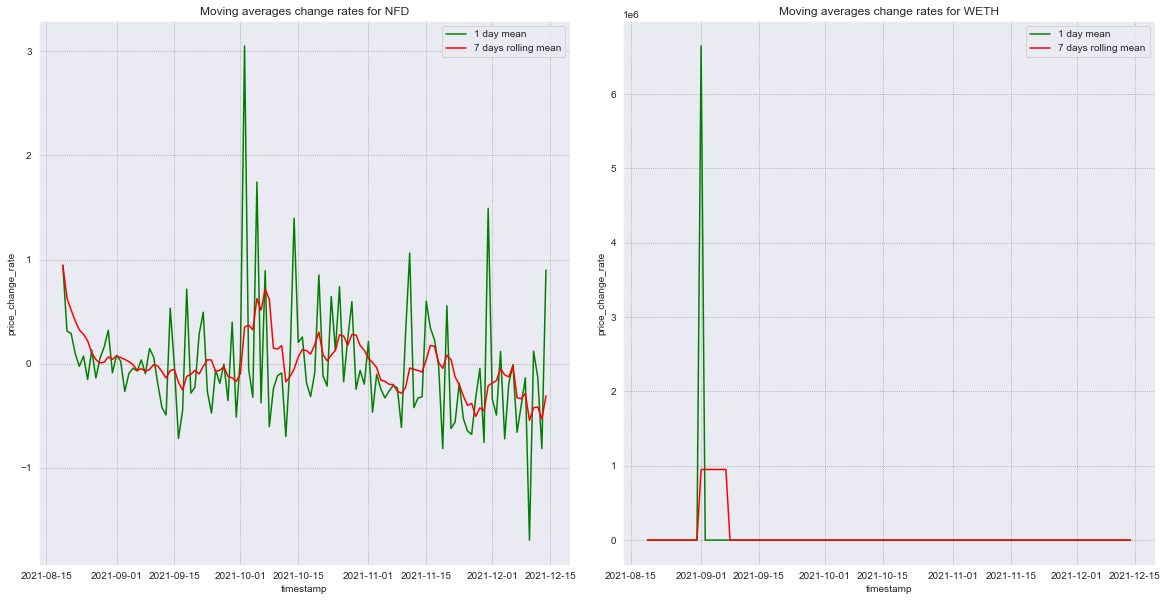

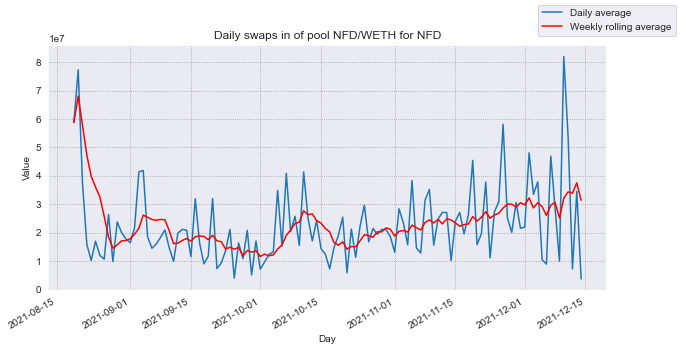

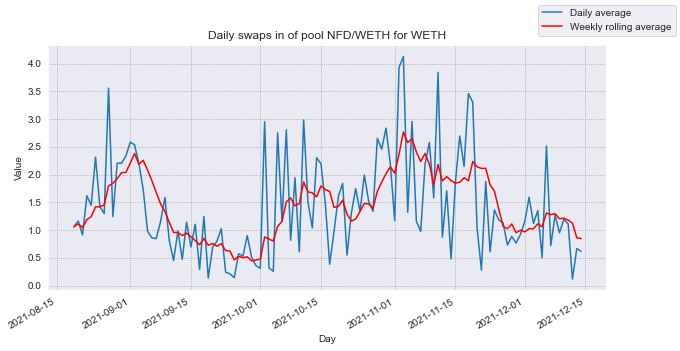

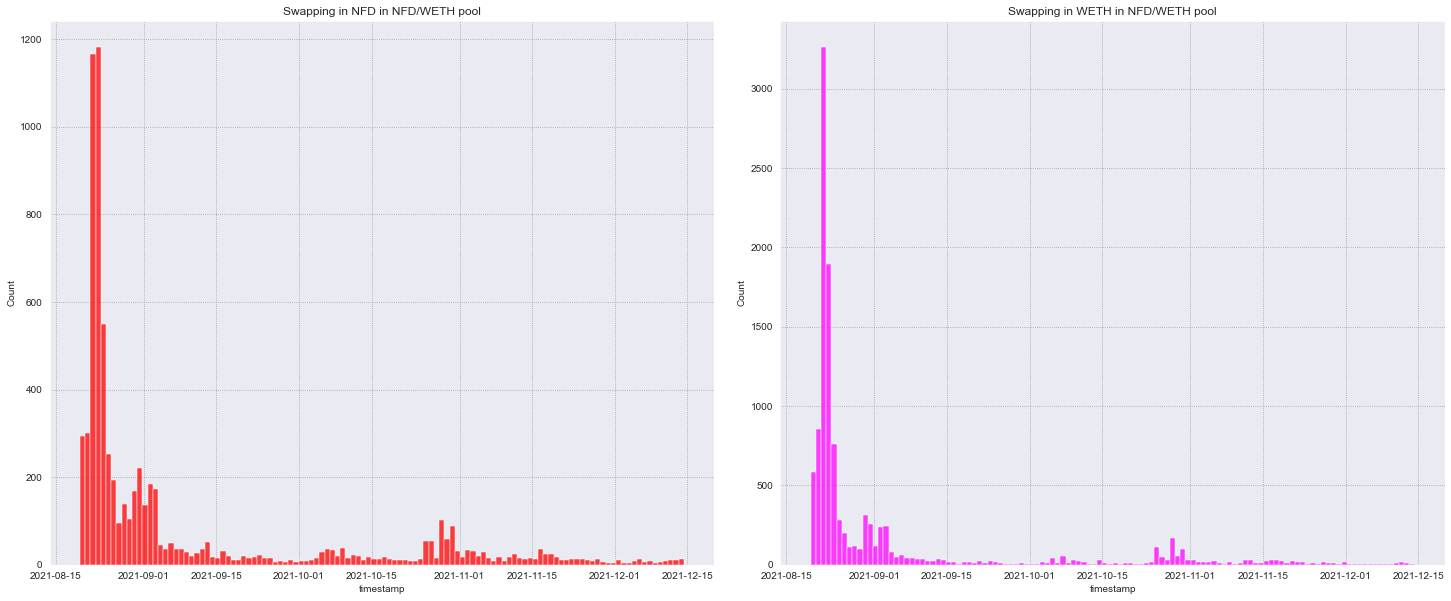

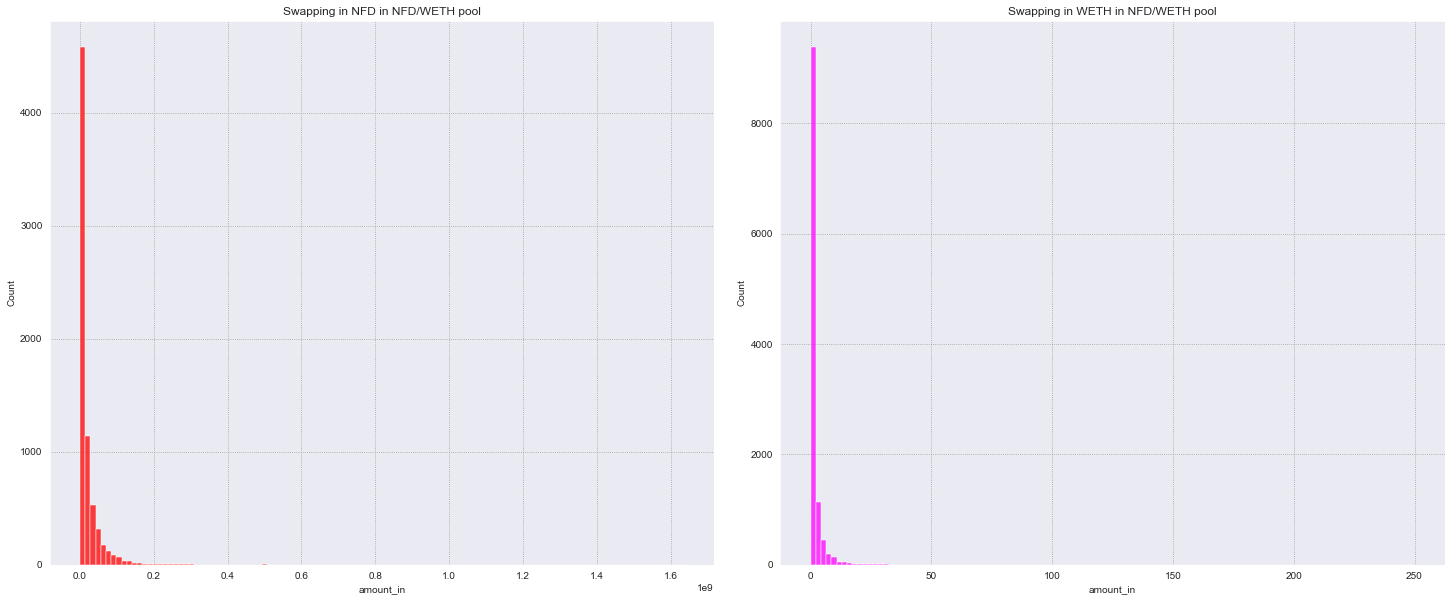

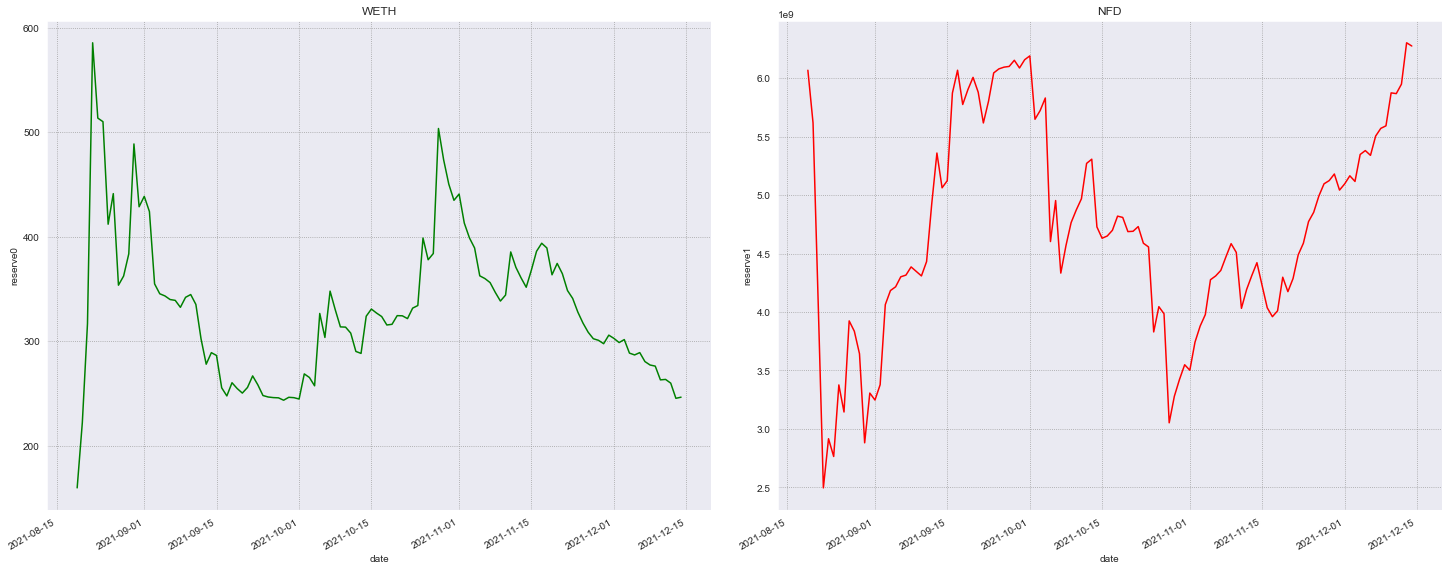

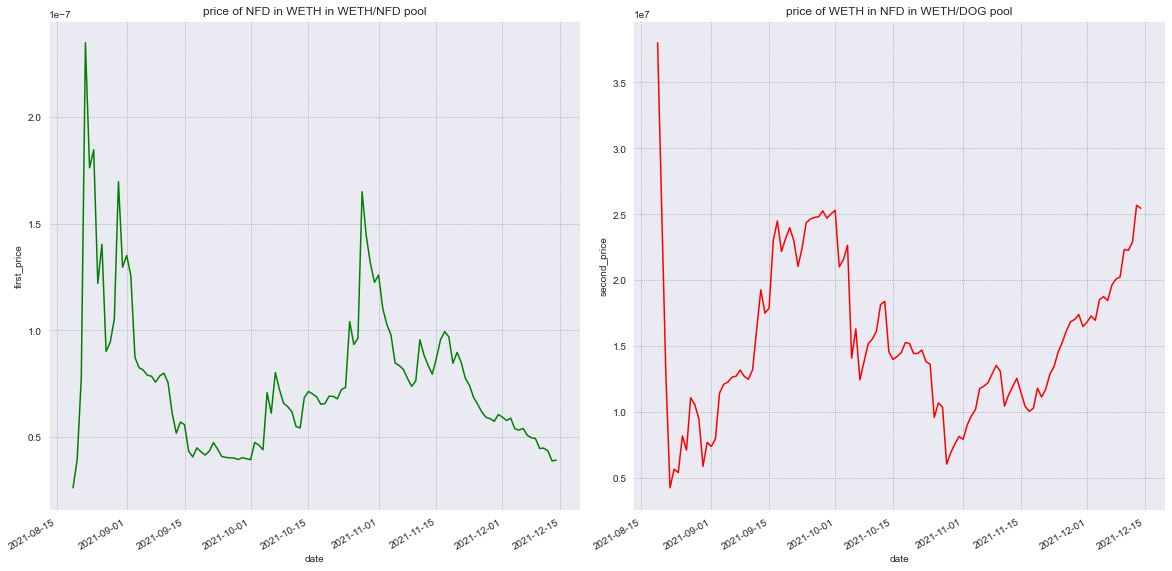

In [33]:
nfd_weth_df = get_df_with_swap_prices_and_change_rates(nfd_weth_df, 'NFD', 'WETH')

pyplot_line_swap_prices(nfd_weth_df, 'NFD', 'WETH', xsize=20, ysize=10, wspace=0.1, hspace=0.1)

pyplot_line_swap_change_rate(nfd_weth_df, 'NFD', 'WETH', xsize=20, ysize=10, wspace=0.1, hspace=0.1)

swaps_price_change_rates_moving_averages(nfd_weth_df, 'NFD', 'WETH', 'Moving averages change rates for NFD',
                                           'Moving averages change rates for WETH', x_size=20, y_size=10, wspace=0.1, hspace=0.1)

show_swaps_amount_in_moving_averages(swaps_df=nfd_weth_df[(nfd_weth_df.token_in == 'NFD')], pool_name="NFD/WETH for NFD")
show_swaps_amount_in_moving_averages(swaps_df=nfd_weth_df[(nfd_weth_df.token_in == 'WETH')], pool_name="NFD/WETH for WETH")

# swapping values histograms
plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
sns.histplot(data=nfd_weth_df[nfd_weth_df.token_in == 'NFD'], x='timestamp', 
             bins=(nfd_weth_df.timestamp[len(nfd_weth_df) - 1] - nfd_weth_df.timestamp[0]).days, 
             color='red').set_title("Swapping in NFD in NFD/WETH pool")
plt.subplot(1, 2, 2)
sns.histplot(data=nfd_weth_df[nfd_weth_df.token_in == 'WETH'], x='timestamp', 
             bins=(nfd_weth_df.timestamp[len(nfd_weth_df) - 1] - nfd_weth_df.timestamp[0]).days, 
             color='magenta').set_title("Swapping in WETH in NFD/WETH pool")
plt.subplots_adjust(wspace=0.1)
plt.show()

# swapping in values distribution
plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
sns.histplot(data=nfd_weth_df[nfd_weth_df.token_in == 'NFD'], x='amount_in', 
             bins=(nfd_weth_df.timestamp[len(nfd_weth_df) - 1] - nfd_weth_df.timestamp[0]).days, 
             color='red').set_title("Swapping in NFD in NFD/WETH pool")
plt.subplot(1, 2, 2)
sns.histplot(data=nfd_weth_df[nfd_weth_df.token_in == 'WETH'], x='amount_in', 
             bins=(nfd_weth_df.timestamp[len(nfd_weth_df) - 1] - nfd_weth_df.timestamp[0]).days, 
             color='magenta').set_title("Swapping in WETH in NFD/WETH pool")
plt.subplots_adjust(wspace=0.1)
plt.show()

show_reserves_time_distribution(nfd_weth_reserves_df, first_token_reserve_name="WETH", 
                                           second_token_reserve_name="NFD", x=25, y=10, wspace=0.1)

show_reserve_price_distributions(nfd_weth_reserves_df, first_token_price_name="price of NFD in WETH in WETH/NFD pool", 
                                        second_token_price_name="price of WETH in NFD in WETH/DOG pool", x=20, y=10, wspace=0.1)

In [15]:
nfd_weth_df[nfd_weth_df.price_change_rate > 10000][
    ['token_in', 'token_out', 'amount_in', 'amount_out', 'amount_usd', 'timestamp', 
     'first_to_second_price', 'price_change_rate']
]

token_in token_out  amount_in  amount_out   amount_usd  \
13572     WETH       NFD   2.710541  20000000.0  9537.998213   

                timestamp  first_to_second_price  price_change_rate  
13572 2021-09-01 06:45:22           7.378600e+06       7.378599e+08

In [16]:
nfd_weth_df[(nfd_weth_df.index > 13560) & (nfd_weth_df.index < 13580)][
    ['token_in', 'token_out', 'amount_in', 'amount_out', 'amount_usd', 'timestamp', 
     'first_to_second_price', 'price_change_rate']
]

token_in token_out     amount_in    amount_out    amount_usd  \
13561      NFD      WETH  5.091563e+07  6.534754e+00  2.276703e+04   
13562     WETH       NFD  6.483100e+00  5.091563e+07  2.258706e+04   
13563     WETH       NFD  3.000000e+00  2.304244e+07  1.045197e+04   
13564     WETH       NFD  5.559957e+00  4.316226e+07  1.949529e+04   
13565      NFD      WETH  8.347105e+06  1.080082e+00  3.787178e+03   
13566     WETH       NFD  5.640345e-01  4.338124e+06  1.978064e+03   
13567     WETH       NFD  5.271339e+00  4.000000e+07  1.852758e+04   
13568     WETH       NFD  3.000000e+00  2.233462e+07  1.056523e+04   
13569      NFD      WETH  7.742061e+06  1.038356e+00  3.656824e+03   
13570     WETH       NFD  1.417488e-01  1.052724e+06  4.985336e+02   
13571     WETH       NFD  1.000000e-18  1.000000e-18  3.516481e-15   
13572     WETH       NFD  2.710541e+00  2.000000e+07  9.537998e+03   
13573     WETH       NFD  5.639545e+00  3.960985e+07  1.985895e+04   
13574     WETH       NFD  6.780500e+00  4.896822e+07  2.387668e+04   
13575      NFD      WETH  4.896822e+07  6.910437e+00  2.433424e+04   
13576      NFD      WETH  1.126053e+07  1.559228e+00  5.490572e+03   
13577      NFD      WETH  1.561943e+07  2.144763e+00  7.560969e+03   
13578      NFD      WETH  1.244373e+07  1.693871e+00  5.971266e+03   
13579     WETH       NFD  1.475296e+01  1.046441e+08  5.201656e+04   

                timestamp  first_to_second_price  price_change_rate  
13561 2021-09-01 05:16:27           1.283447e-07       2.780126e+00  
13562 2021-09-01 05:16:27           7.853594e+06      -1.789453e+00  
13563 2021-09-01 05:16:27           7.680815e+06      -2.200001e+00  
13564 2021-09-01 05:49:30           7.763056e+06       1.070741e+00  
13565 2021-09-01 05:49:35           1.293960e-07       8.191124e-01  
13566 2021-09-01 05:50:37           7.691239e+06      -9.251177e-01  
13567 2021-09-01 05:53:08           7.588204e+06      -1.339633e+00  
13568 2021-09-01 06:00:42           7.444873e+06      -1.888875e+00  
13569 2021-09-01 06:00:42           1.341188e-07       3.649863e+00  
13570 2021-09-01 06:37:03           7.426690e+06      -2.442355e-01  
13571 2021-09-01 06:42:52           1.000000e+00      -9.999999e+01  
13572 2021-09-01 06:45:22           7.378600e+06       7.378599e+08  
13573 2021-09-01 06:55:02           7.023591e+06      -4.811339e+00  
13574 2021-09-01 06:55:02           7.221919e+06       2.823743e+00  
13575 2021-09-01 06:55:02           1.411209e-07       5.220790e+00  
13576 2021-09-01 06:58:29           1.384684e-07      -1.879581e+00  
13577 2021-09-01 07:07:14           1.373137e-07      -8.338645e-01  
13578 2021-09-01 07:08:16           1.361224e-07      -8.675721e-01  
13579 2021-09-01 07:10:22           7.093091e+06      -1.783841e+00

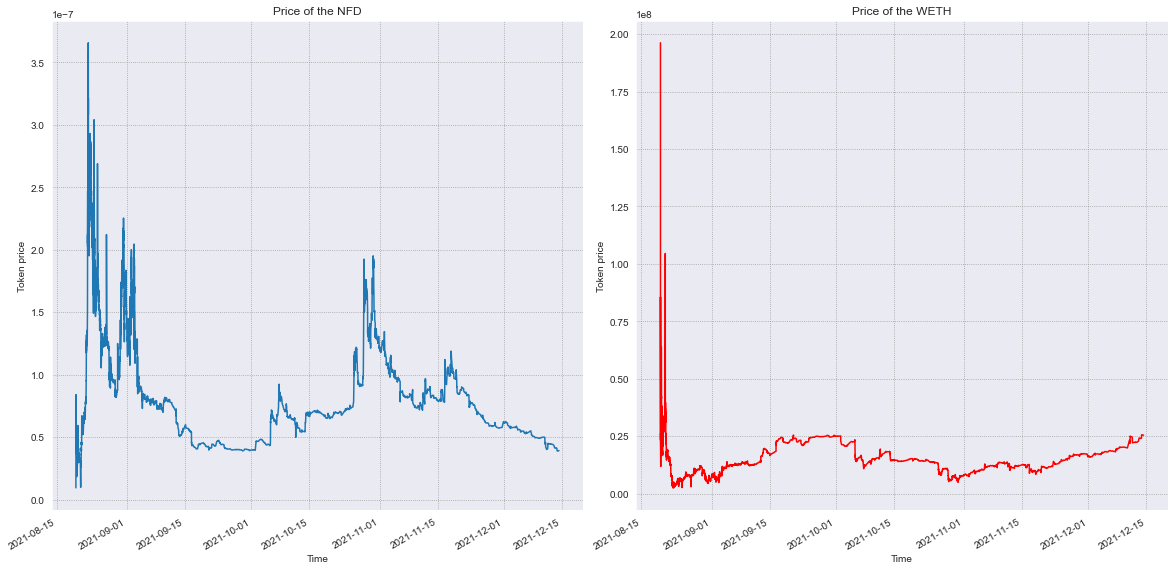

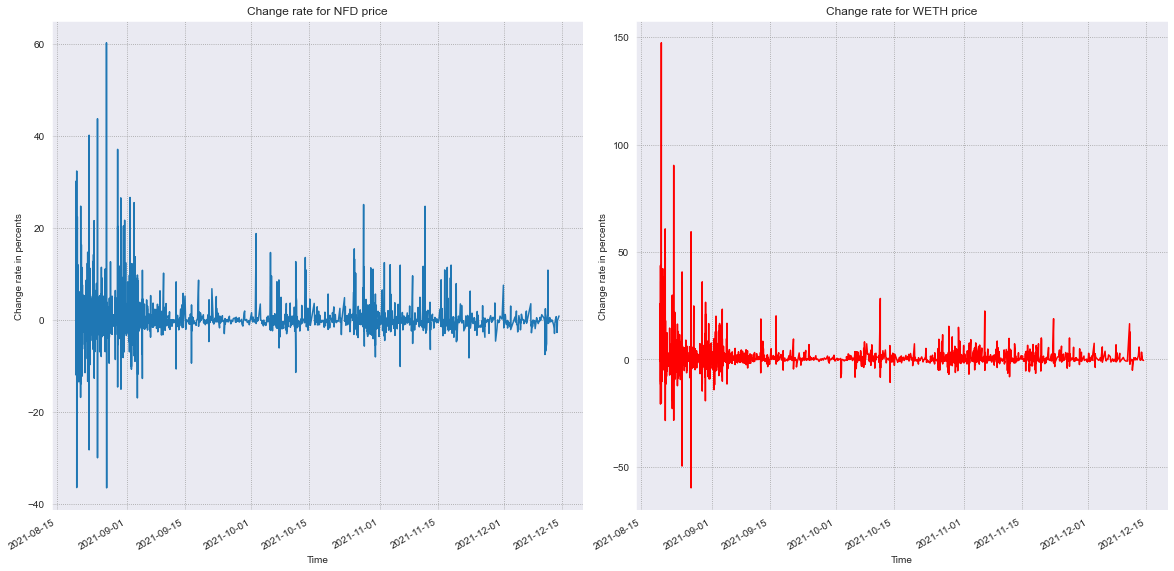

In [17]:
pyplot_line_swap_prices(nfd_weth_df[(nfd_weth_df.price_change_rate > -99) & 
                                    (nfd_weth_df.price_change_rate < 10000)], 'NFD', 'WETH', xsize=20, ysize=10, wspace=0.1, hspace=0.1)
pyplot_line_swap_change_rate(nfd_weth_df[(nfd_weth_df.price_change_rate > -99) & 
                                         (nfd_weth_df.price_change_rate < 10000)], 'NFD', 'WETH', xsize=20, ysize=10, wspace=0.1, hspace=0.1)

In [18]:
nfd_weth_df[nfd_weth_df.price_change_rate > 100]

token_in token_out  amount_in    amount_out   amount_usd  \
430       WETH       NFD   0.050000  3.196709e+06   157.851254   
13572     WETH       NFD   2.710541  2.000000e+07  9537.998213   

                timestamp                                      sender  \
430   2021-08-19 21:08:05  0xd9e1ce17f2641f24ae83637ab66a2cca9c378b9f   
13572 2021-09-01 06:45:22  0xd9e1ce17f2641f24ae83637ab66a2cca9c378b9f   

                                               to  \
430    0xe7a1006ea1d26742a10f60f996c310daa013a898   
13572  0xd1ac0e75c931e7e7363d6a9b262699b45d0b3177   

                                                     txd  \
430    0x36ef7a2f724df6302ab2acc0a6b0a320c5f70d9f8c2b...   
13572  0xec301869356756106ee2867ea011b64d9b5aef727618...   

       first_to_second_price  price_change_rate  
430             6.393417e+07       1.474325e+02  
13572           7.378600e+06       7.378599e+08

In [19]:
nfd_weth_df[(nfd_weth_df.index > 410) & (nfd_weth_df.index < 432)][
    ['token_in', 'token_out', 'amount_in', 'amount_out', 'amount_usd', 'timestamp', 
     'first_to_second_price', 'price_change_rate']
]

token_in token_out     amount_in    amount_out    amount_usd  \
411      NFD      WETH  8.452847e+07  3.977821e+00  12534.568739   
412     WETH       NFD  6.751820e-02  1.500000e+06    212.757554   
413     WETH       NFD  1.982500e-02  4.399295e+05     62.471089   
414      NFD      WETH  6.971550e+07  3.000000e+00   9452.675117   
415      NFD      WETH  7.571881e+07  3.000000e+00   9456.507825   
416      NFD      WETH  5.393461e+07  1.990145e+00   6273.450728   
417     WETH       NFD  1.000000e-01  2.769097e+06    315.219228   
418      NFD      WETH  5.599428e+06  2.007013e-01    632.825092   
419     WETH       NFD  7.500000e-01  2.063305e+07   2367.213417   
420      NFD      WETH  4.513924e+07  1.610230e+00   5082.361798   
421     WETH       NFD  8.760288e-04  2.500000e+04      2.764642   
422     WETH       NFD  4.000000e-01  1.134729e+07   1262.361662   
423     WETH       NFD  1.680792e+00  4.624475e+07   5304.294044   
424     WETH       NFD  1.543720e+01  3.387241e+08  48717.061605   
425     WETH       NFD  1.914300e+00  3.355713e+07   6041.190827   
426      NFD      WETH  3.387241e+08  1.599973e+01  50492.291856   
427     WETH       NFD  3.000000e-02  7.751712e+05     94.672233   
428      NFD      WETH  4.624475e+07  1.735813e+00   5478.086068   
429      NFD      WETH  1.000000e+09  2.386395e+01  75375.432567   
430     WETH       NFD  5.000000e-02  3.196709e+06    157.851254   
431     WETH       NFD  4.000000e-02  2.555494e+06    126.279167   

              timestamp  first_to_second_price  price_change_rate  
411 2021-08-19 20:33:14           4.705895e-08          -4.262671  
412 2021-08-19 20:35:01           2.221623e+07          10.264675  
413 2021-08-19 20:35:12           2.219064e+07          -0.115178  
414 2021-08-19 20:40:30           4.303204e-08          -8.557161  
415 2021-08-19 20:41:41           3.962027e-08          -7.928427  
416 2021-08-19 20:43:35           3.689921e-08          -6.867851  
417 2021-08-19 20:45:35           2.769097e+07          24.786680  
418 2021-08-19 20:46:18           3.584318e-08          -2.861933  
419 2021-08-19 20:53:05           2.751074e+07          -0.650865  
420 2021-08-19 20:56:33           3.567251e-08          -0.476177  
421 2021-08-19 20:59:07           2.853788e+07           3.733588  
422 2021-08-19 20:59:49           2.836822e+07          -0.594486  
423 2021-08-19 21:00:47           2.751366e+07          -3.012374  
424 2021-08-19 21:02:04           2.194207e+07         -20.250295  
425 2021-08-19 21:02:04           1.752971e+07         -20.109102  
426 2021-08-19 21:02:04           4.723528e-08          32.413679  
427 2021-08-19 21:02:55           2.583904e+07          47.401373  
428 2021-08-19 21:05:34           3.753535e-08         -20.535349  
429 2021-08-19 21:06:34           2.386395e-08         -36.422727  
430 2021-08-19 21:08:05           6.393417e+07         147.432471  
431 2021-08-19 21:09:18           6.388735e+07          -0.073238

# LADY/WETH

In [20]:
lady_weth_df = pd.read_pickle(os.getcwd() + '\\pkl_stories\\lady_weth_swaps.pkl')
lady_weth_mints_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\lady_weth_mints.pkl")
# lady_weth_burns_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\lady_weth_burns.pkl")
lady_weth_reserves_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\lady_weth_reserves.pkl")

C:\Users\Zbook\anaconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


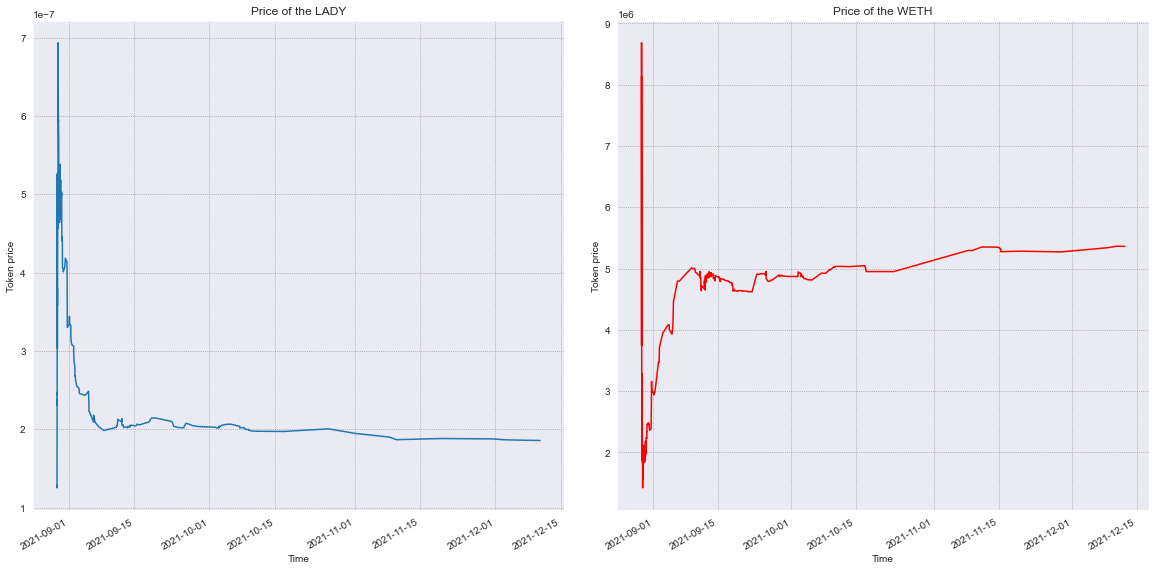

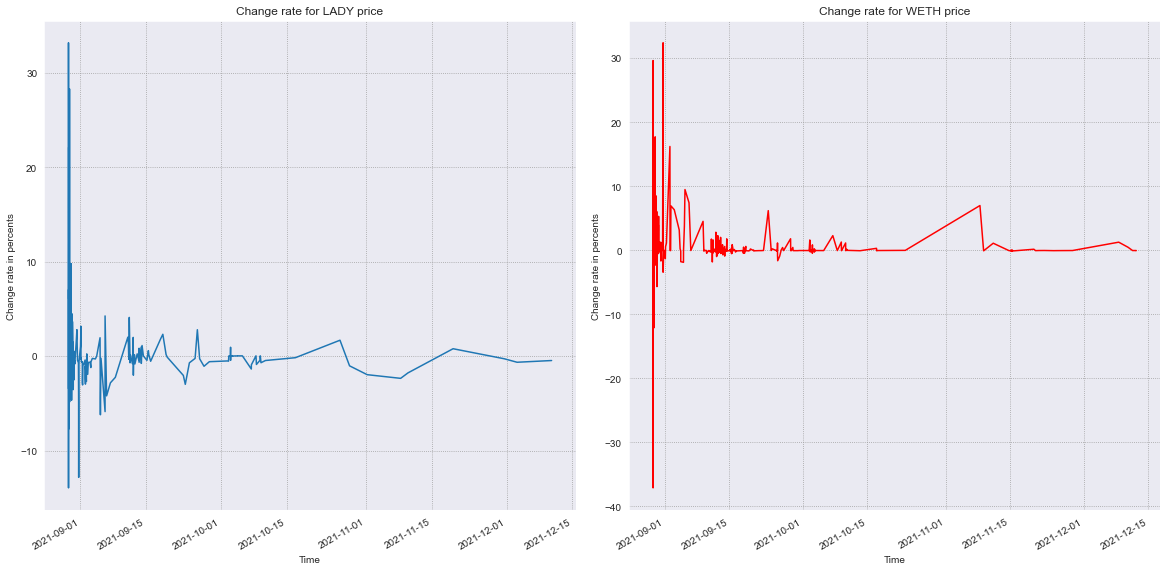

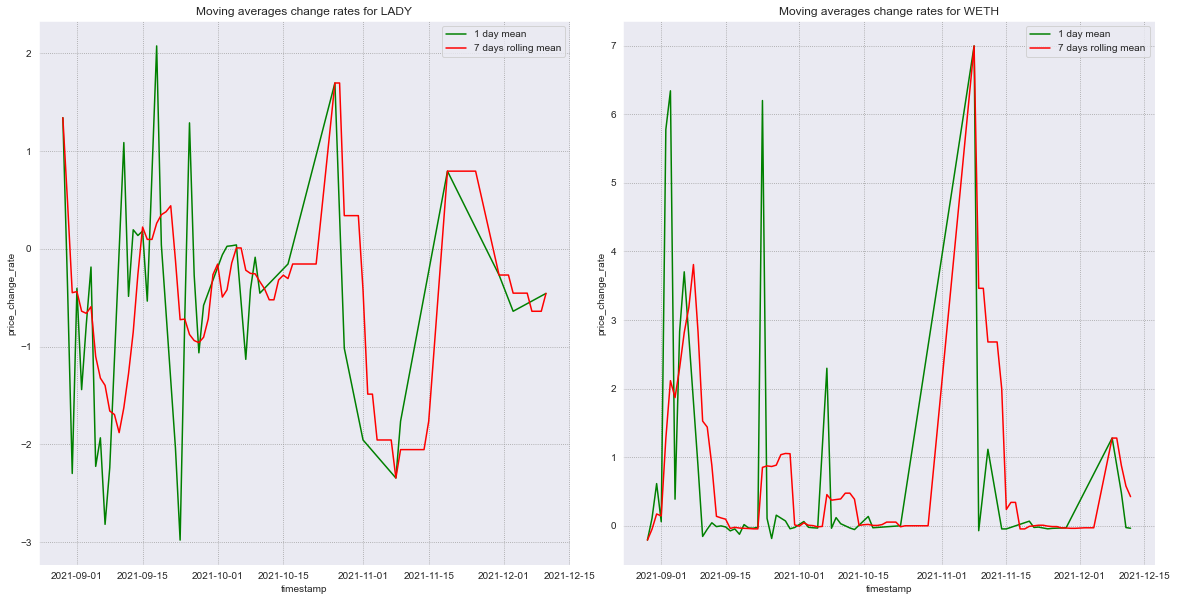

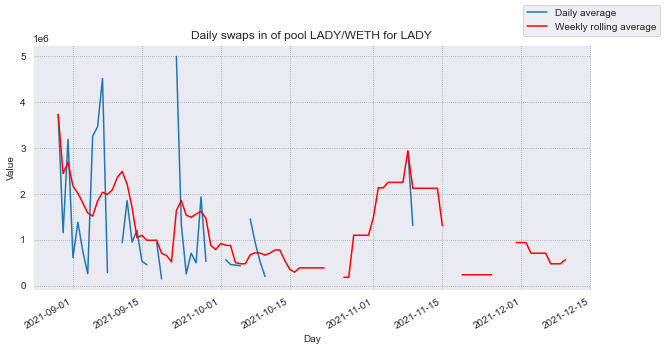

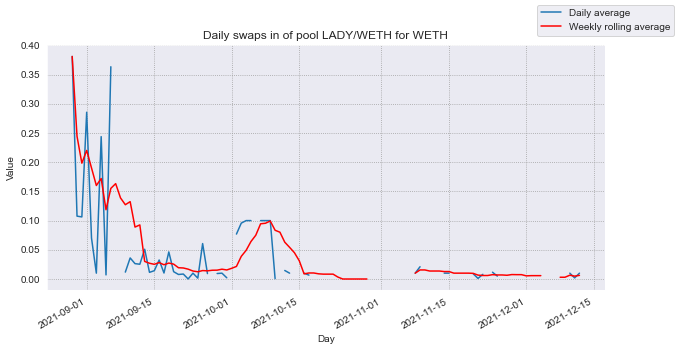

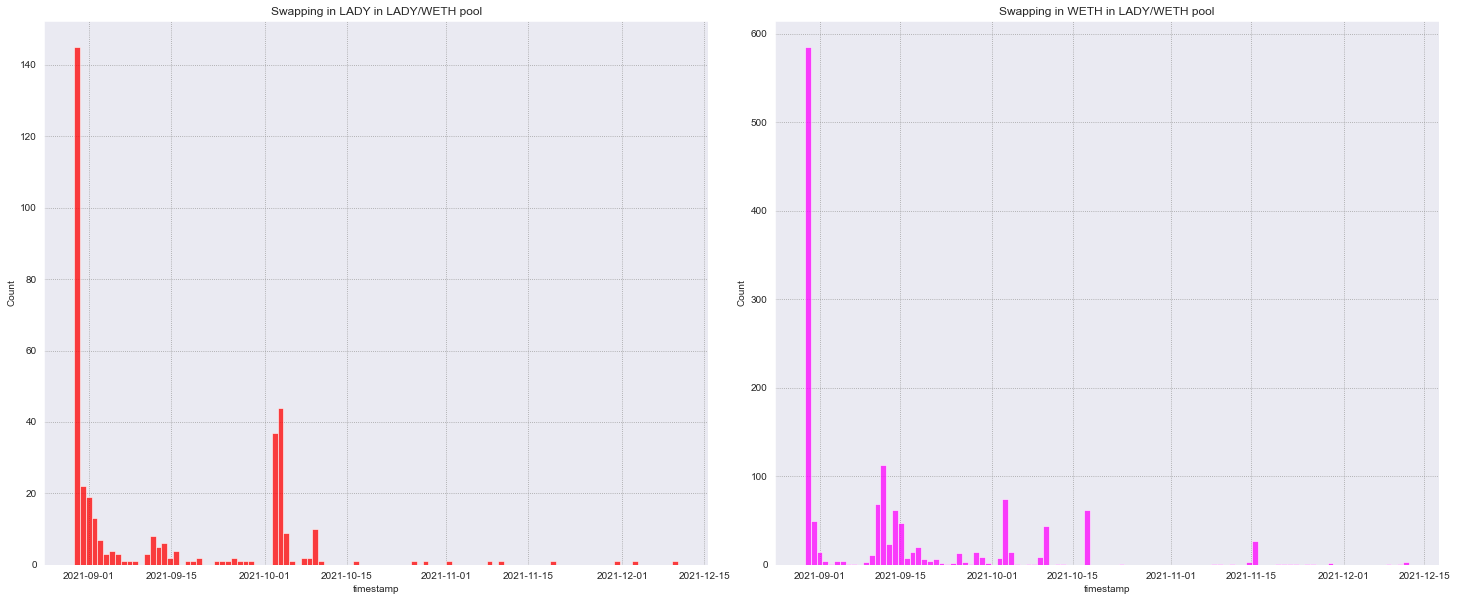

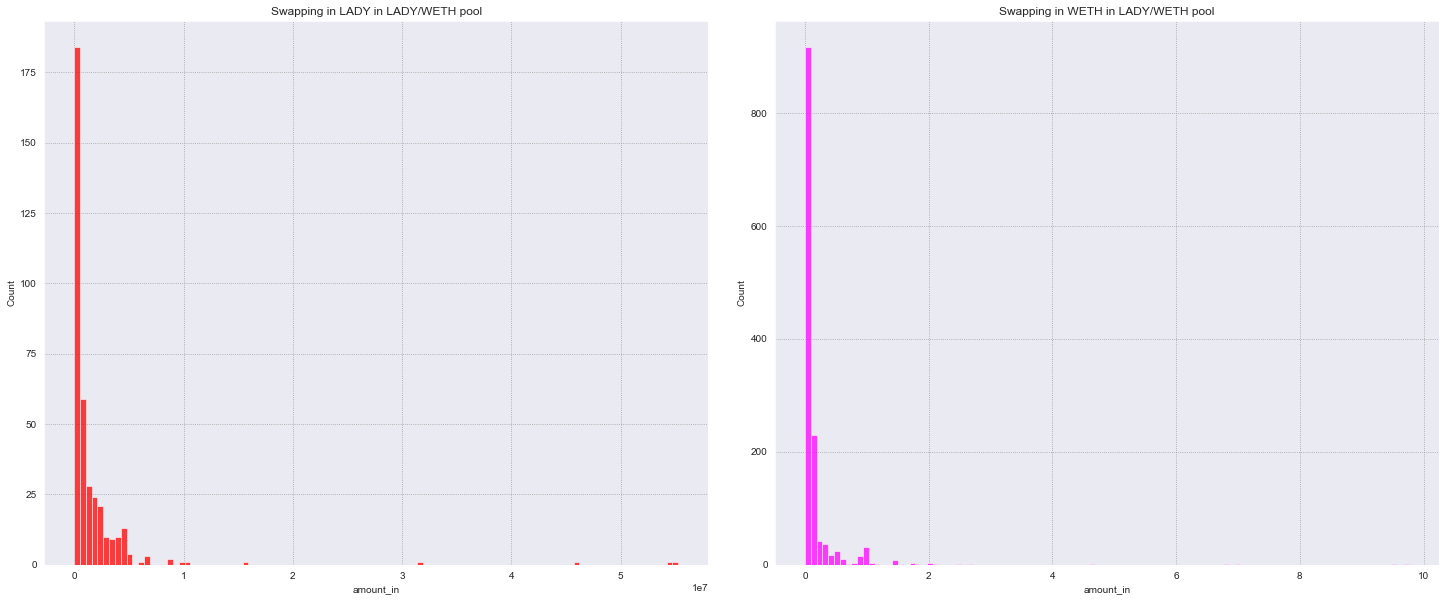

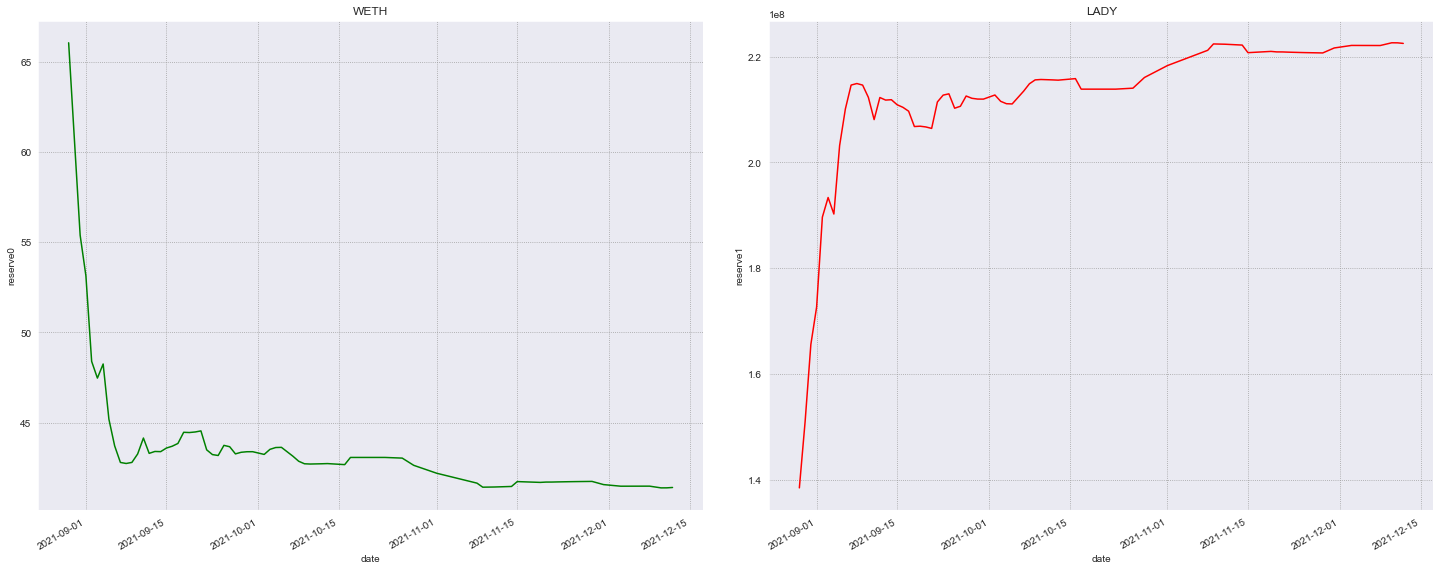

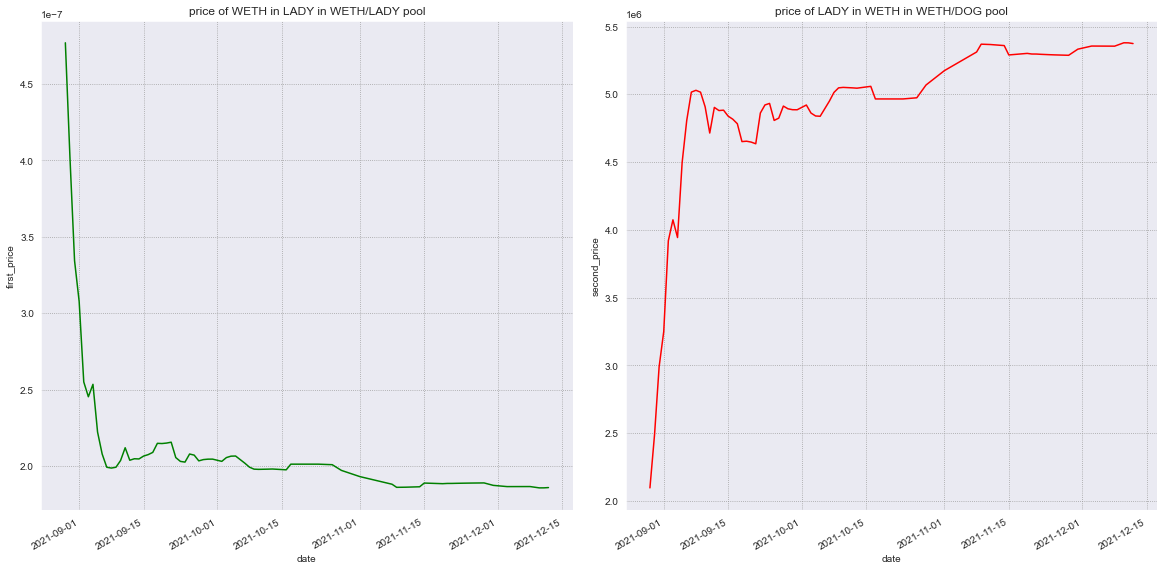

In [32]:
lady_weth_df = get_df_with_swap_prices_and_change_rates(lady_weth_df, 'LADY', 'WETH')

pyplot_line_swap_prices(lady_weth_df, 'LADY', 'WETH', xsize=20, ysize=10, wspace=0.1, hspace=0.1)

pyplot_line_swap_change_rate(lady_weth_df, 'LADY', 'WETH', xsize=20, ysize=10, wspace=0.1, hspace=0.1)

swaps_price_change_rates_moving_averages(lady_weth_df, 'LADY', 'WETH', 'Moving averages change rates for LADY',
                                           'Moving averages change rates for WETH', x_size=20, y_size=10, wspace=0.1, hspace=0.1)

show_swaps_amount_in_moving_averages(swaps_df=lady_weth_df[(lady_weth_df.token_in == 'LADY')], pool_name="LADY/WETH for LADY")
show_swaps_amount_in_moving_averages(swaps_df=lady_weth_df[(lady_weth_df.token_in == 'WETH')], pool_name="LADY/WETH for WETH")

# swapping values histograms
plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
sns.histplot(data=lady_weth_df[lady_weth_df.token_in == 'LADY'], x='timestamp', 
             bins=(lady_weth_df.timestamp[len(lady_weth_df) - 1] - lady_weth_df.timestamp[0]).days, 
             color='red').set_title("Swapping in LADY in LADY/WETH pool")
plt.subplot(1, 2, 2)
sns.histplot(data=lady_weth_df[lady_weth_df.token_in == 'WETH'], x='timestamp', 
             bins=(lady_weth_df.timestamp[len(lady_weth_df) - 1] - lady_weth_df.timestamp[0]).days, 
             color='magenta').set_title("Swapping in WETH in LADY/WETH pool")
plt.subplots_adjust(wspace=0.1)
plt.show()

# swapping in values distribution
plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
sns.histplot(data=lady_weth_df[lady_weth_df.token_in == 'LADY'], x='amount_in', 
             bins=(lady_weth_df.timestamp[len(lady_weth_df) - 1] - lady_weth_df.timestamp[0]).days, 
             color='red').set_title("Swapping in LADY in LADY/WETH pool")
plt.subplot(1, 2, 2)
sns.histplot(data=lady_weth_df[lady_weth_df.token_in == 'WETH'], x='amount_in', 
             bins=(lady_weth_df.timestamp[len(lady_weth_df) - 1] - lady_weth_df.timestamp[0]).days, 
             color='magenta').set_title("Swapping in WETH in LADY/WETH pool")
plt.subplots_adjust(wspace=0.1)
plt.show()

show_reserves_time_distribution(lady_weth_reserves_df, first_token_reserve_name="WETH", 
                                second_token_reserve_name="LADY", x=25, y=10, wspace=0.1)

show_reserve_price_distributions(lady_weth_reserves_df, first_token_price_name="price of WETH in LADY in WETH/LADY pool", 
                                        second_token_price_name="price of LADY in WETH in WETH/DOG pool", x=20, y=10, wspace=0.1)

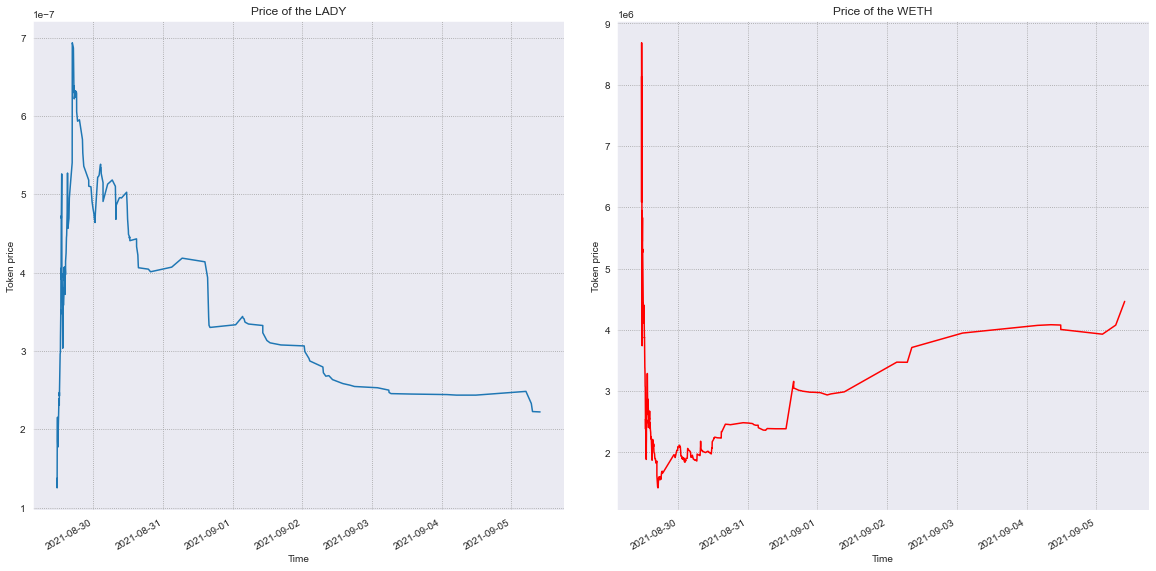

In [23]:
pyplot_line_swap_prices(lady_weth_df[lady_weth_df.timestamp < datetime(2021, 9, 6)], 'LADY', 'WETH', xsize=20, ysize=10, wspace=0.1, hspace=0.1)

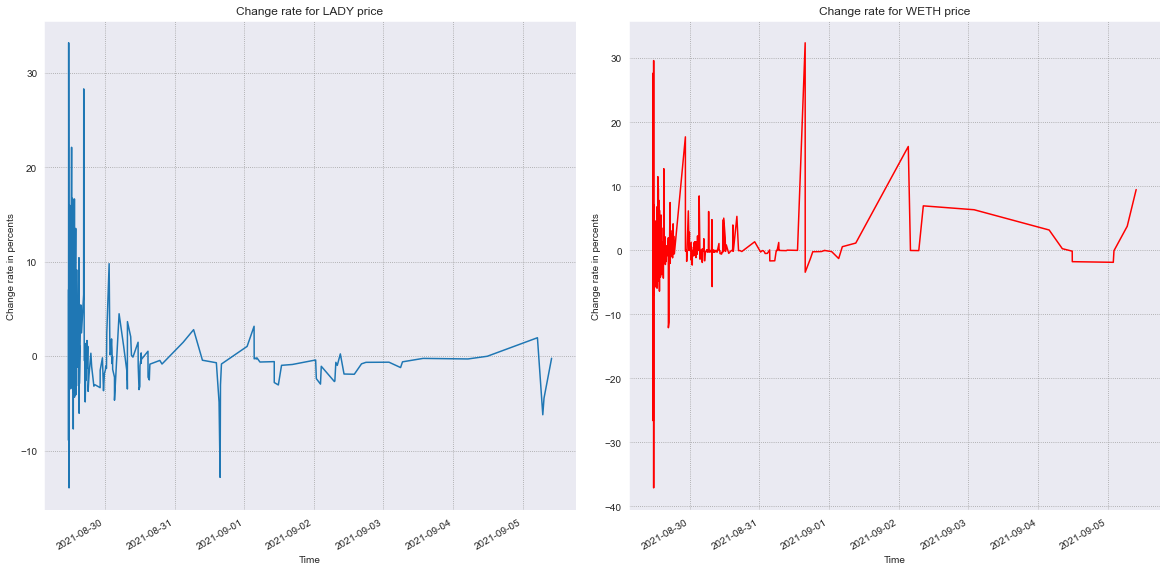

In [45]:
pyplot_line_swap_change_rate(lady_weth_df[lady_weth_df.timestamp < datetime(2021, 9, 6)], 'LADY', 'WETH', xsize=20, ysize=10, wspace=0.1, hspace=0.1)


In [46]:
lady_weth_df[lady_weth_df.price_change_rate < -30]

token_in token_out  amount_in    amount_out   amount_usd  \
38     WETH      LADY        0.5  1.870353e+06  1599.206305   

             timestamp                                      sender  \
38 2021-08-29 11:37:51  0xd9e1ce17f2641f24ae83637ab66a2cca9c378b9f   

                                            to  \
38  0xf47588a5a54a0a2a1de1863a88a120bbc0b4b777   

                                                  txd  first_to_second_price  \
38  0x24ca7673208624a4001b2ffb674bc3f729440666d552...           3.740705e+06   

    price_change_rate  
38         -37.099605

In [24]:
lady_weth_df[(lady_weth_df.index < 50) & (lady_weth_df.index > 30)][
    ['token_in', 'token_out', 'amount_in', 'amount_out', 'amount_usd', 'timestamp', 
     'first_to_second_price', 'price_change_rate']
]

token_in token_out     amount_in    amount_out    amount_usd  \
31     LADY      WETH  1.704775e+06  3.671787e-01   1175.158268   
32     WETH      LADY  1.000000e+00  4.550603e+06   3198.676772   
33     WETH      LADY  1.000000e-02  5.899570e+04     31.984126   
34     WETH      LADY  1.000000e-01  5.916212e+05    319.841261   
35     WETH      LADY  1.028308e-01  6.115380e+05    328.895243   
36     LADY      WETH  3.170277e+07  6.119274e+00  19573.578911   
37     LADY      WETH  4.609734e+07  9.893984e+00  31645.044338   
38     WETH      LADY  5.000000e-01  1.870353e+06   1599.206305   
39     WETH      LADY  9.761349e+00  4.609734e+07  31220.823300   
40     WETH      LADY  1.000000e+00  5.370542e+06   3198.396037   
41     LADY      WETH  5.867906e+06  1.083816e+00   3466.472847   
42     WETH      LADY  1.039001e+00  5.867906e+06   3323.138167   
43     WETH      LADY  1.000000e-01  5.512833e+05    319.826243   
44     WETH      LADY  4.000000e-01  2.178250e+06   1279.479022   
45     LADY      WETH  8.841136e+06  1.567308e+00   5013.382876   
46     WETH      LADY  3.000000e-03  1.749223e+04      9.583144   
47     WETH      LADY  1.000000e-03  5.830152e+03      3.194725   
48     WETH      LADY  1.773740e+00  9.896196e+06   5666.610104   
49     WETH      LADY  1.000000e-01  5.655276e+05    319.491329   

             timestamp  first_to_second_price  price_change_rate  
31 2021-08-29 11:35:58           2.153825e-07           9.424711  
32 2021-08-29 11:37:43           4.550603e+06          -5.772733  
33 2021-08-29 11:37:46           5.899570e+06          29.643694  
34 2021-08-29 11:37:46           5.916212e+06           0.282095  
35 2021-08-29 11:37:46           5.947030e+06           0.520906  
36 2021-08-29 11:37:46           1.930202e-07         -10.382600  
37 2021-08-29 11:37:51           2.146324e-07          11.196873  
38 2021-08-29 11:37:51           3.740705e+06         -37.099605  
39 2021-08-29 11:37:51           4.722436e+06          26.244524  
40 2021-08-29 11:38:14           5.370542e+06          13.723992  
41 2021-08-29 11:38:14           1.847024e-07         -13.944796  
42 2021-08-29 11:38:14           5.647639e+06           5.159573  
43 2021-08-29 11:39:37           5.512833e+06          -2.386945  
44 2021-08-29 11:40:46           5.445625e+06          -1.219123  
45 2021-08-29 11:42:42           1.772745e-07          -4.021530  
46 2021-08-29 11:44:15           5.830745e+06           7.072092  
47 2021-08-29 11:45:19           5.830152e+06          -0.010157  
48 2021-08-29 11:45:47           5.579283e+06          -4.302960  
49 2021-08-29 11:45:47           5.655276e+06           1.362043

# CAT/WETH

In [25]:
cat_weth_df = pd.read_pickle(os.getcwd() + '\\pkl_stories\\cat_weth_swaps.pkl')
cat_weth_mints_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\cat_weth_mints.pkl")
# cat_weth_burns_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\cat_weth_burns.pkl")
cat_weth_reserves_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\cat_weth_reserves.pkl")

C:\Users\Zbook\anaconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


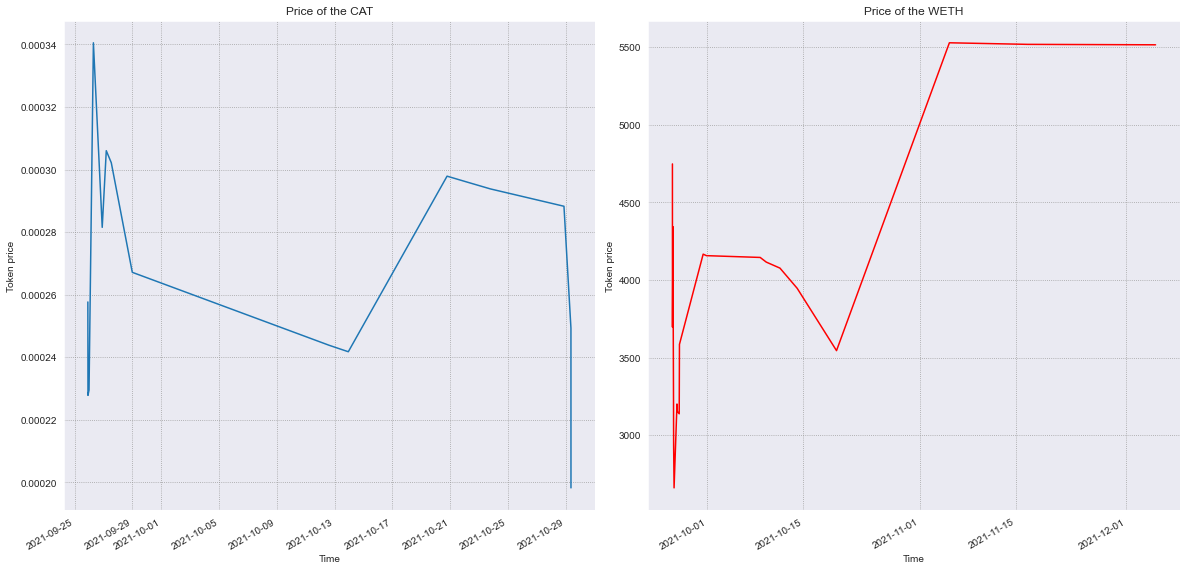

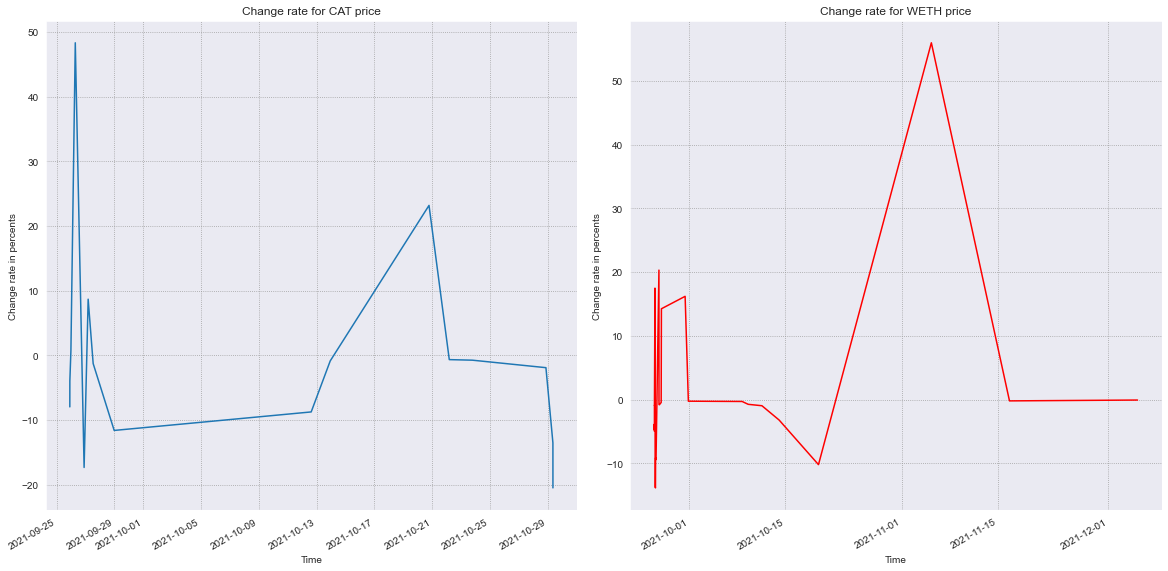

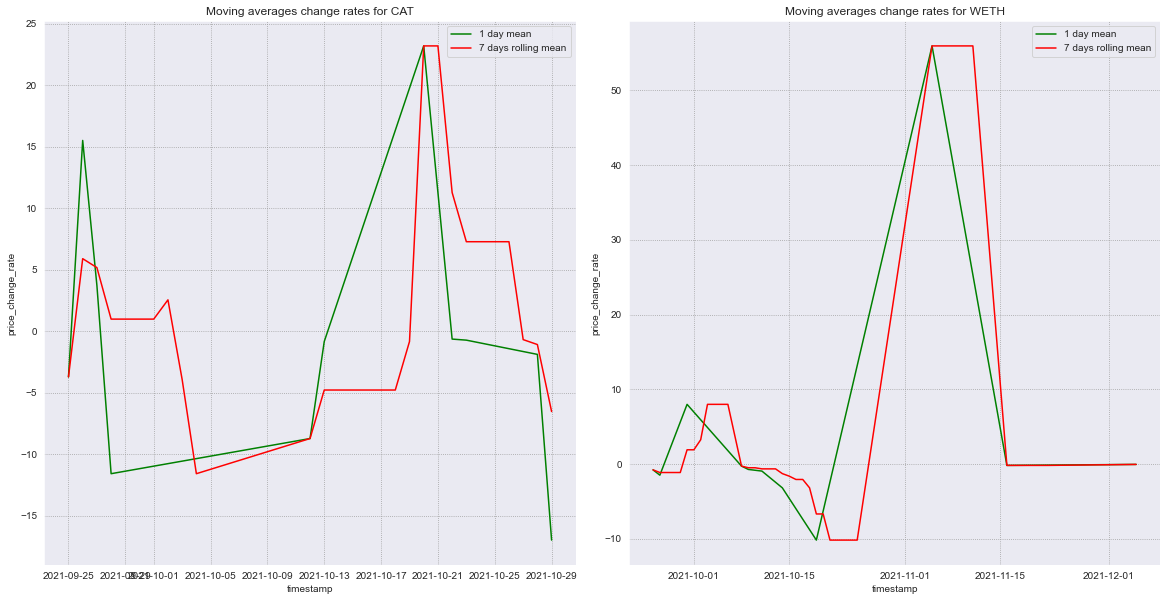

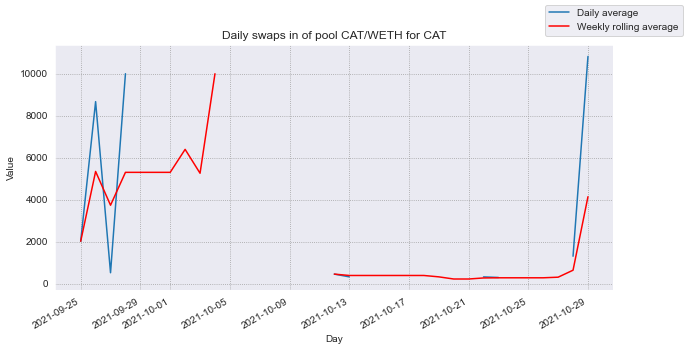

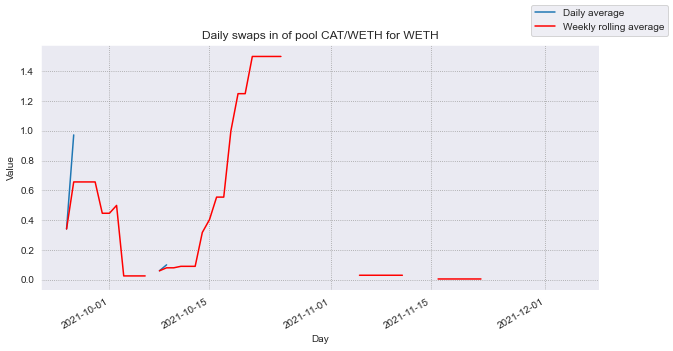

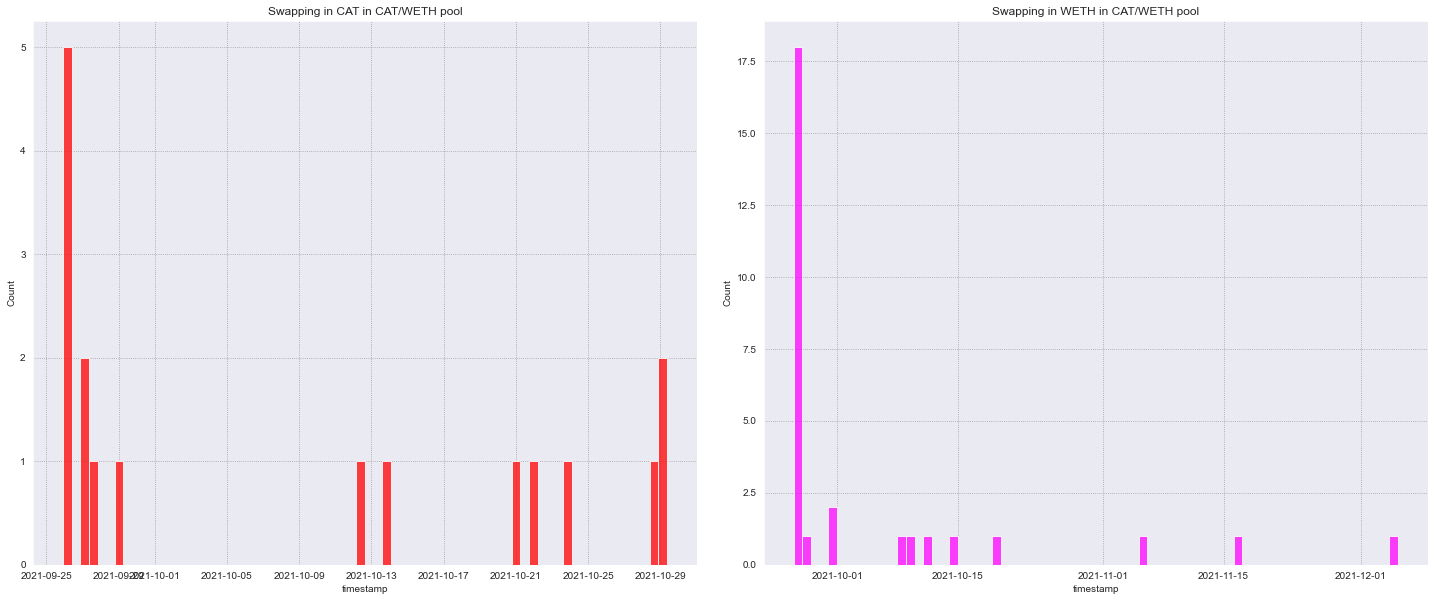

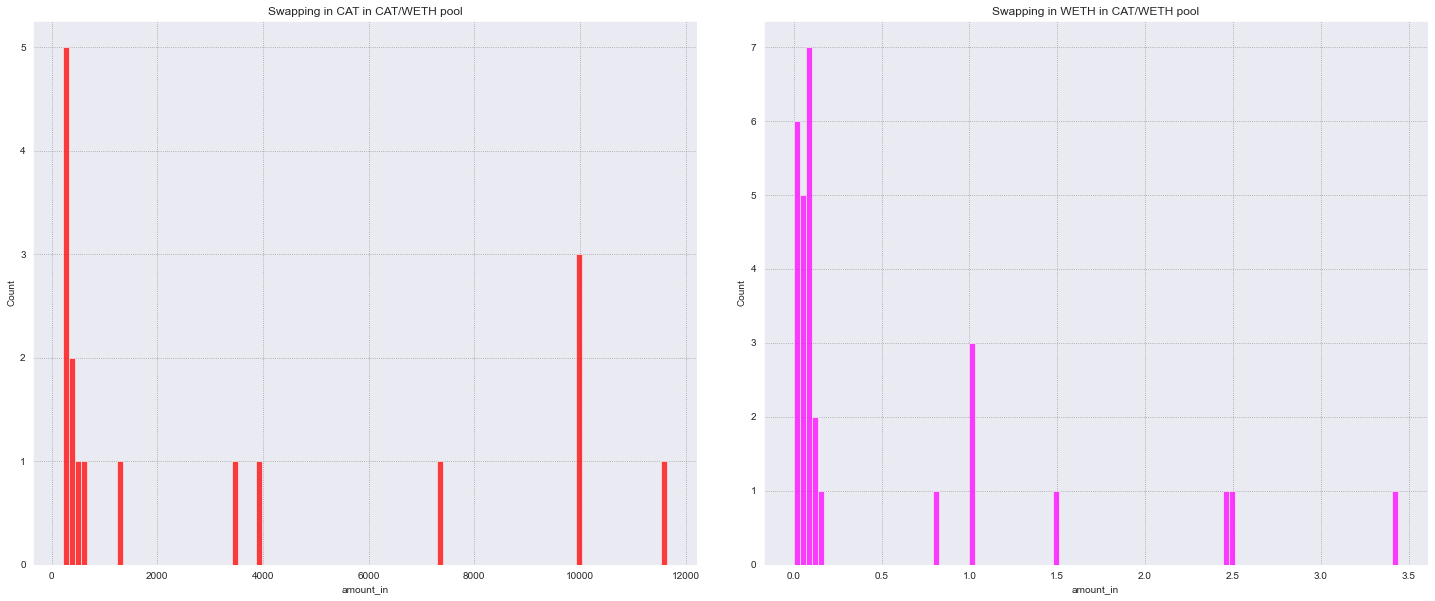

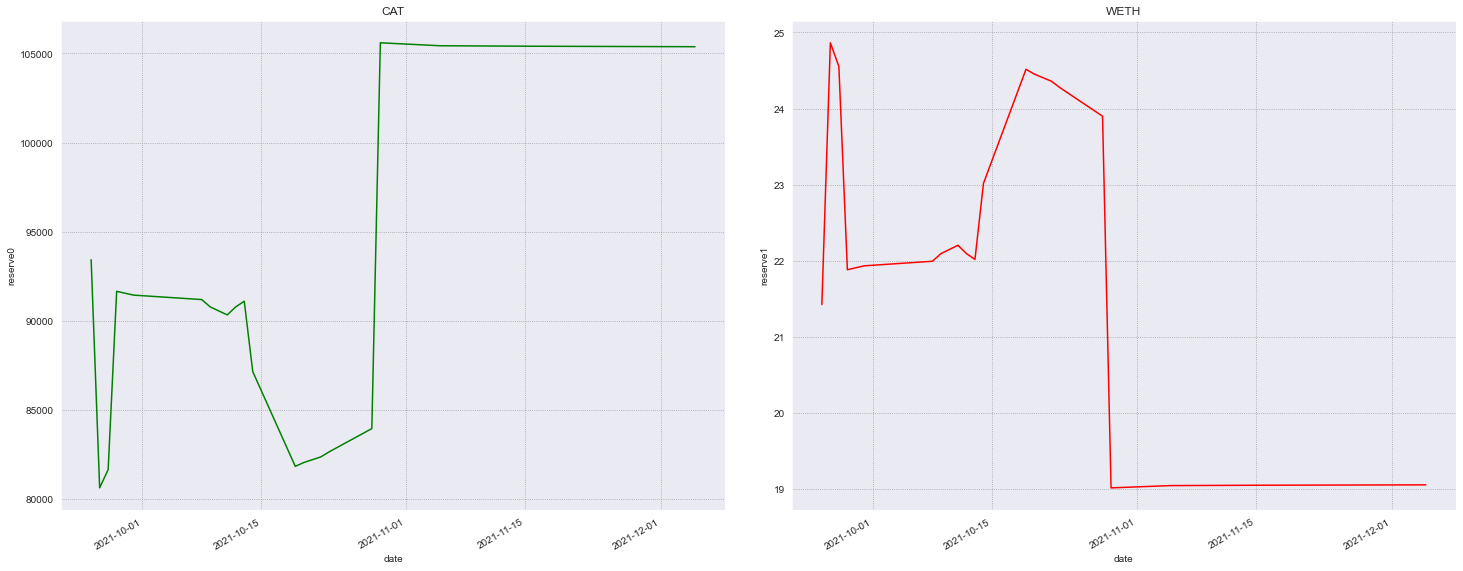

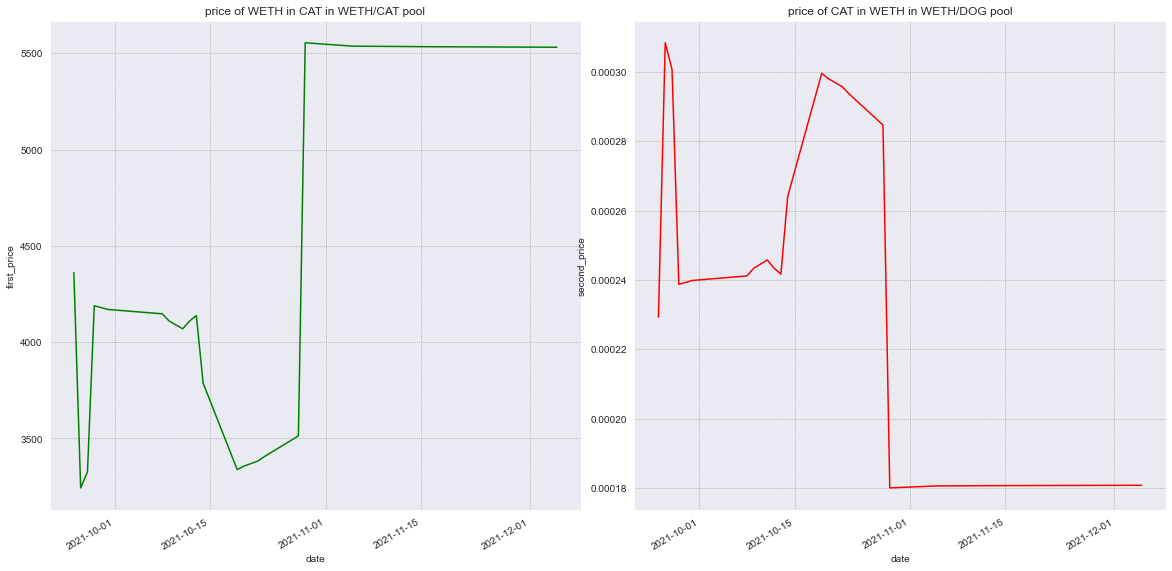

In [35]:
cat_weth_df = get_df_with_swap_prices_and_change_rates(cat_weth_df, 'CAT', 'WETH')

pyplot_line_swap_prices(cat_weth_df, 'CAT', 'WETH', xsize=20, ysize=10, wspace=0.1, hspace=0.1)

pyplot_line_swap_change_rate(cat_weth_df, 'CAT', 'WETH', xsize=20, ysize=10, wspace=0.1, hspace=0.1)

swaps_price_change_rates_moving_averages(cat_weth_df, 'CAT', 'WETH', 'Moving averages change rates for CAT',
                                           'Moving averages change rates for WETH', x_size=20, y_size=10, wspace=0.1, hspace=0.1)

show_swaps_amount_in_moving_averages(swaps_df=cat_weth_df[(cat_weth_df.token_in == 'CAT')], pool_name="CAT/WETH for CAT")
show_swaps_amount_in_moving_averages(swaps_df=cat_weth_df[(cat_weth_df.token_in == 'WETH')], pool_name="CAT/WETH for WETH")

# swapping values histograms
plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
sns.histplot(data=cat_weth_df[cat_weth_df.token_in == 'CAT'], x='timestamp', 
             bins=(cat_weth_df.timestamp[len(cat_weth_df) - 1] - cat_weth_df.timestamp[0]).days, 
             color='red').set_title("Swapping in CAT in CAT/WETH pool")
plt.subplot(1, 2, 2)
sns.histplot(data=cat_weth_df[cat_weth_df.token_in == 'WETH'], x='timestamp',
             bins=(cat_weth_df.timestamp[len(cat_weth_df) - 1] - cat_weth_df.timestamp[0]).days, 
             color='magenta').set_title("Swapping in WETH in CAT/WETH pool")
plt.subplots_adjust(wspace=0.1)
plt.show()

# swapping in values distribution
plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
sns.histplot(data=cat_weth_df[cat_weth_df.token_in == 'CAT'], x='amount_in', bins=100, 
             color='red').set_title("Swapping in CAT in CAT/WETH pool")
plt.subplot(1, 2, 2)
sns.histplot(data=cat_weth_df[cat_weth_df.token_in == 'WETH'], x='amount_in', bins=100, 
             color='magenta').set_title("Swapping in WETH in CAT/WETH pool")
plt.subplots_adjust(wspace=0.1)
plt.show()

show_reserves_time_distribution(cat_weth_reserves_df, first_token_reserve_name="CAT", 
                                           second_token_reserve_name="WETH", x=25, y=10, wspace=0.1)

show_reserve_price_distributions(cat_weth_reserves_df, first_token_price_name="price of WETH in CAT in WETH/CAT pool", 
                                        second_token_price_name="price of CAT in WETH in WETH/DOG pool", x=20, y=10, wspace=0.1)

# TIARA/WETH

In [27]:
tiara_weth_df = pd.read_pickle(os.getcwd() + '\\pkl_stories\\tiara_weth_swaps.pkl')
tiara_weth_mints_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\tiara_weth_mints.pkl")
tiara_weth_burns_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\tiara_weth_burns.pkl")
tiara_weth_reserves_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\tiara_weth_reserves.pkl")

C:\Users\Zbook\anaconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


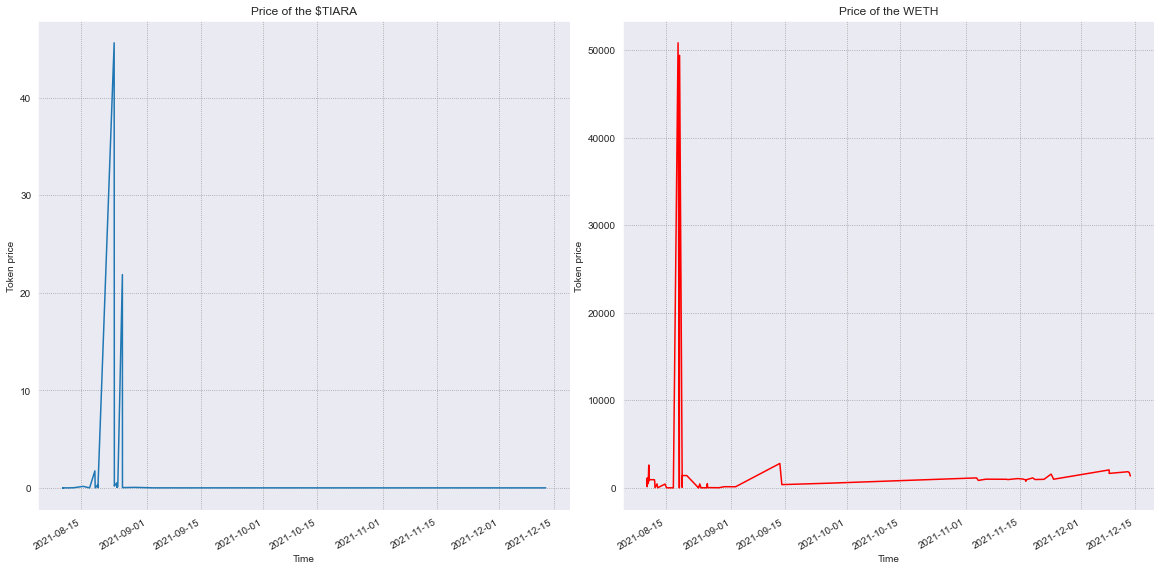

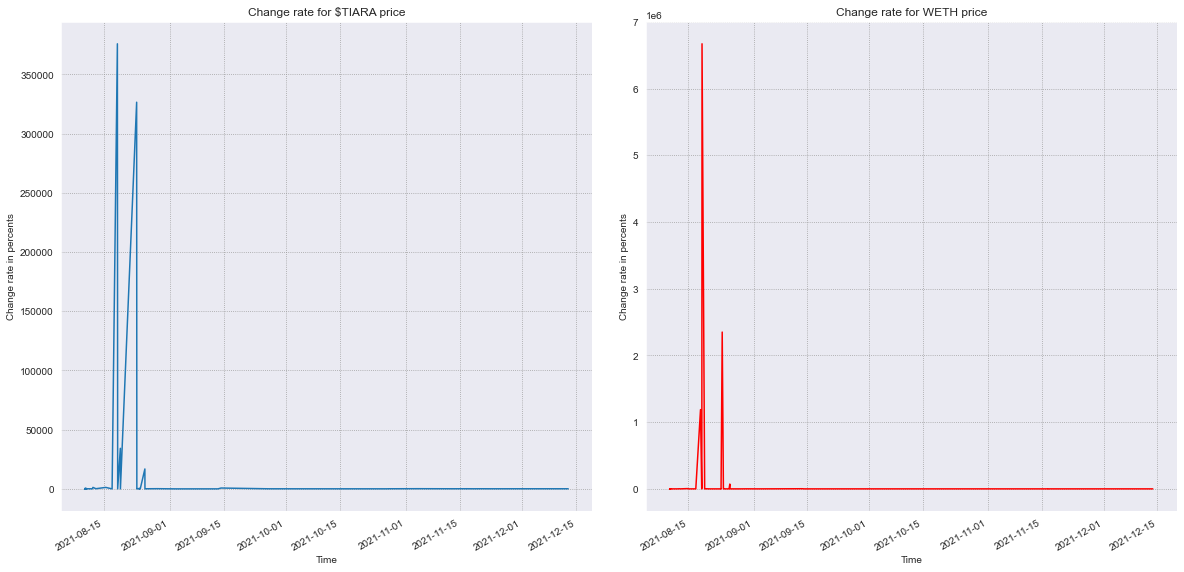

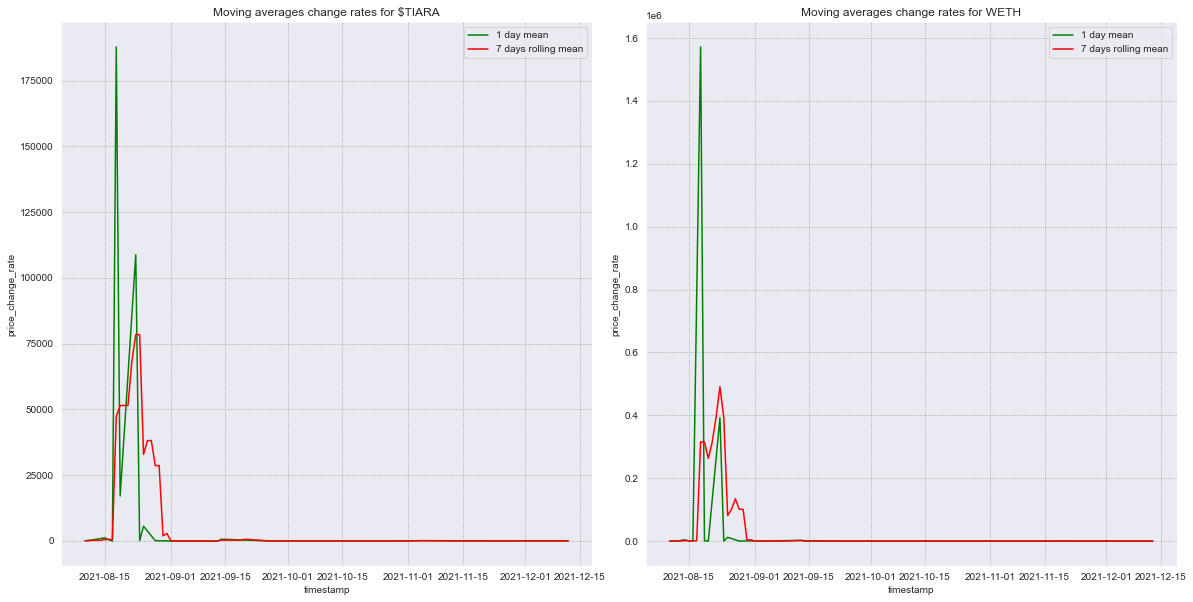

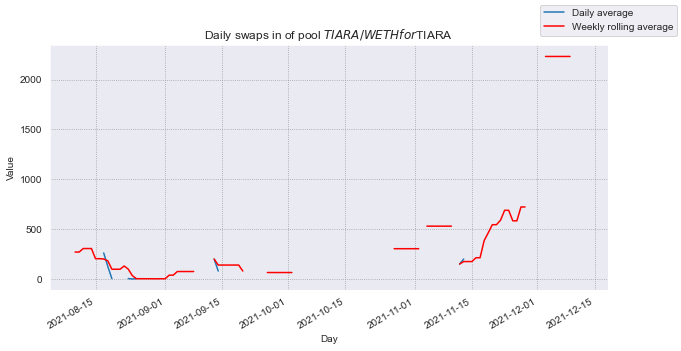

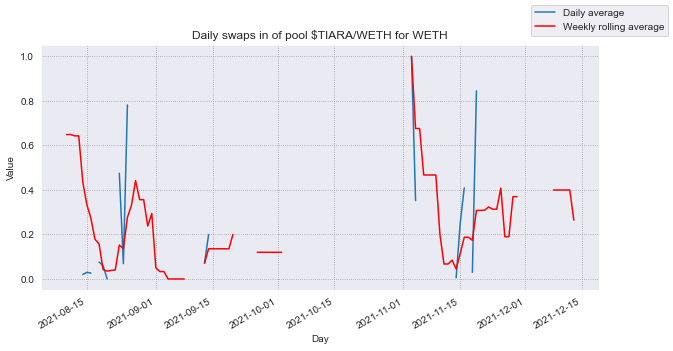

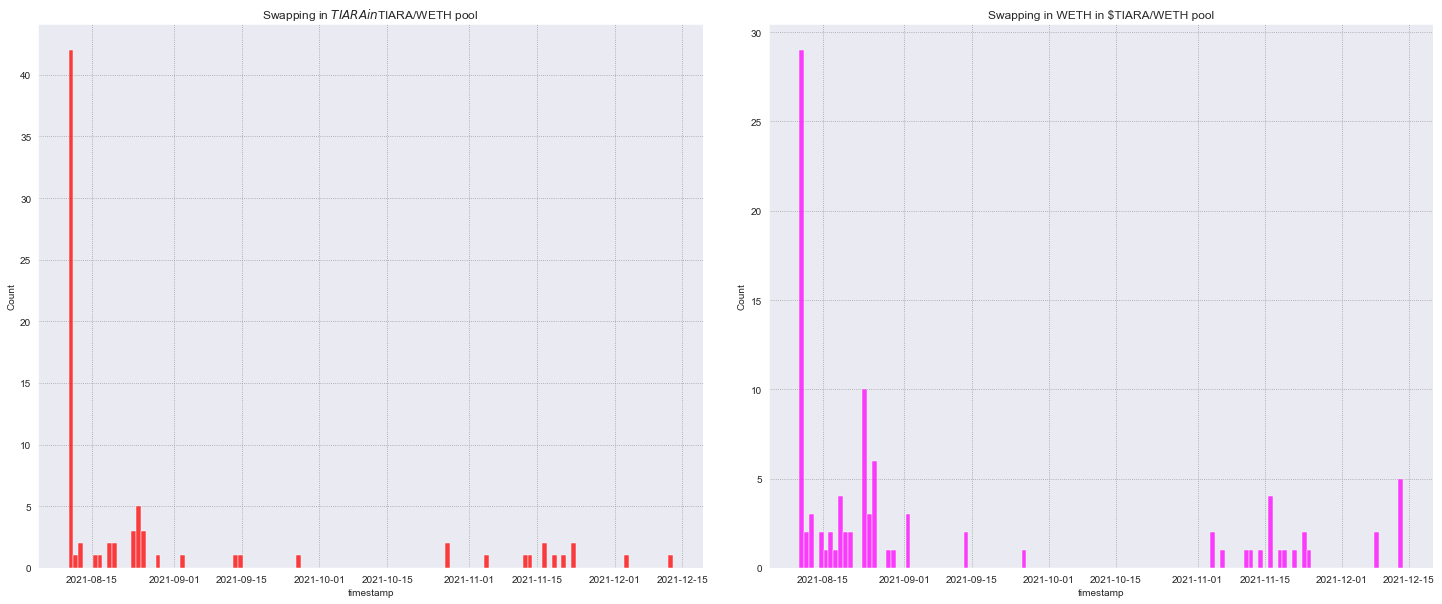

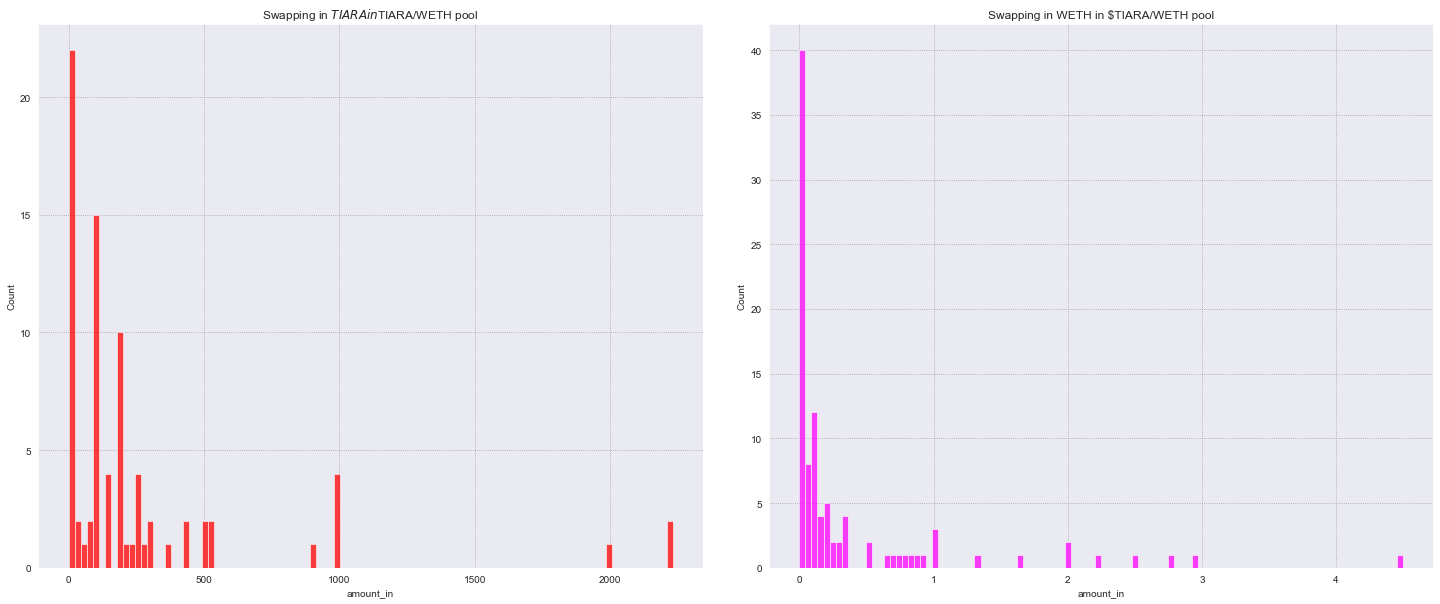

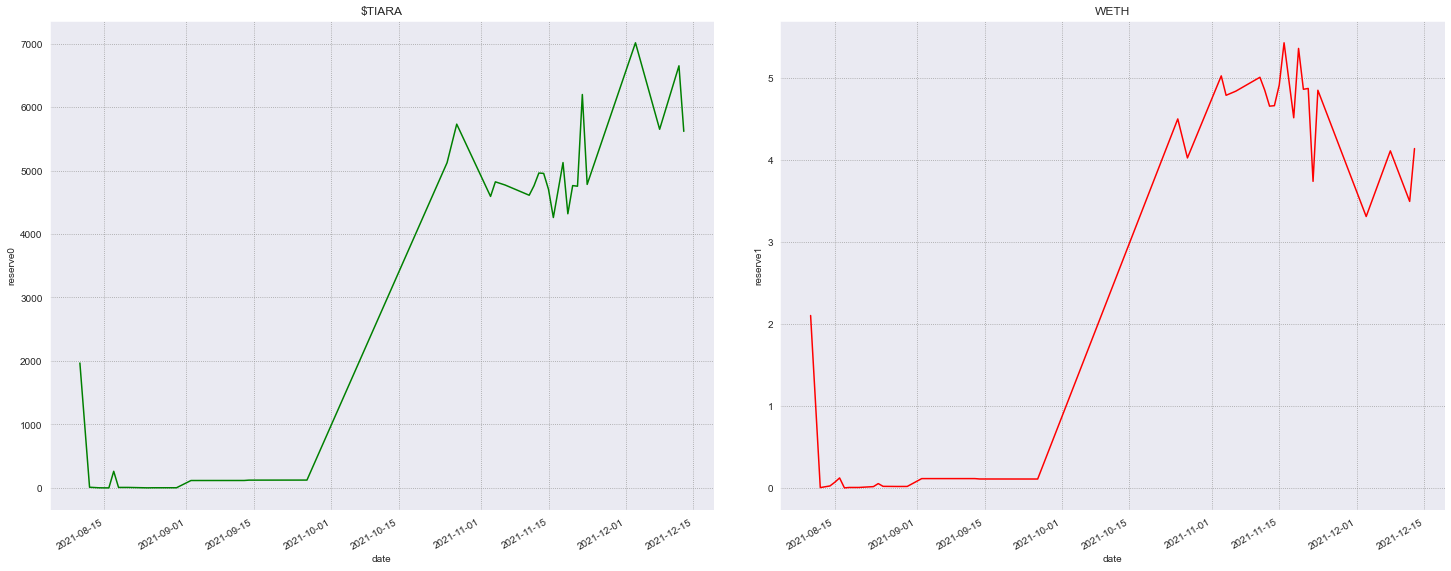

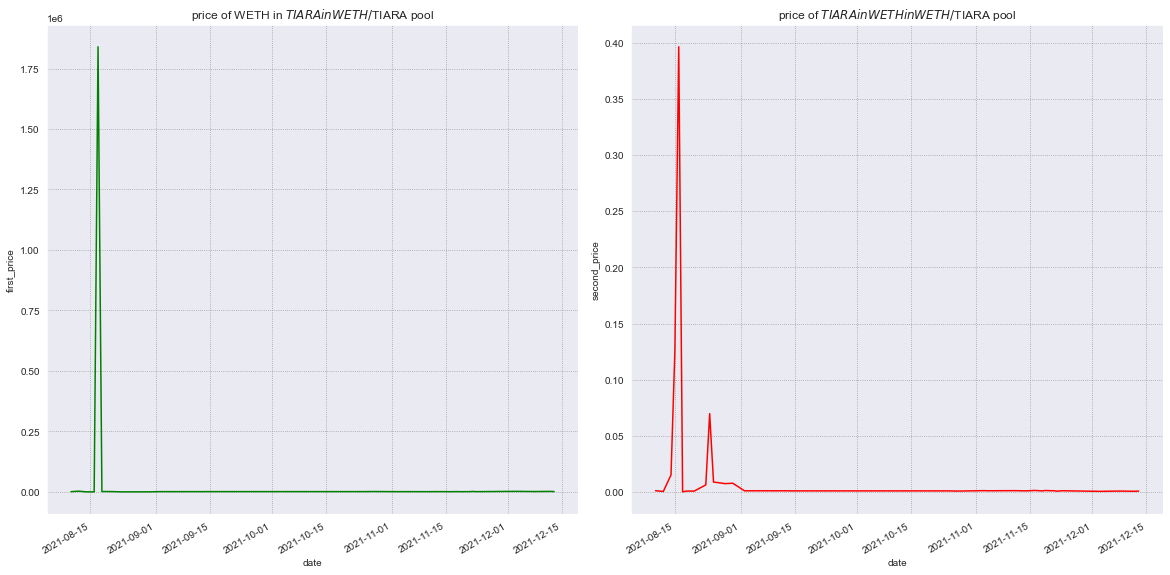

In [36]:
tiara_weth_df = get_df_with_swap_prices_and_change_rates(tiara_weth_df, '$TIARA', 'WETH')

pyplot_line_swap_prices(tiara_weth_df, '$TIARA', 'WETH', xsize=20, ysize=10, wspace=0.1, hspace=0.1)

pyplot_line_swap_change_rate(tiara_weth_df, '$TIARA', 'WETH', xsize=20, ysize=10, wspace=0.1, hspace=0.1)

swaps_price_change_rates_moving_averages(tiara_weth_df, '$TIARA', 'WETH', 'Moving averages change rates for $TIARA',
                                          'Moving averages change rates for WETH', x_size=20, y_size=10, wspace=0.1, hspace=0.1)

show_swaps_amount_in_moving_averages(swaps_df=tiara_weth_df[(tiara_weth_df.token_in == '$TIARA')], pool_name="$TIARA/WETH for $TIARA")
show_swaps_amount_in_moving_averages(swaps_df=tiara_weth_df[(tiara_weth_df.token_in == 'WETH')], pool_name="$TIARA/WETH for WETH")

# swapping values histograms
plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
sns.histplot(data=tiara_weth_df[tiara_weth_df.token_in == '$TIARA'], x='timestamp', 
             bins=(tiara_weth_df.timestamp[len(tiara_weth_df) - 1] - tiara_weth_df.timestamp[0]).days, 
             color='red').set_title("Swapping in $TIARA in $TIARA/WETH pool")
plt.subplot(1, 2, 2)
sns.histplot(data=tiara_weth_df[tiara_weth_df.token_in == 'WETH'], x='timestamp', 
             bins=(tiara_weth_df.timestamp[len(tiara_weth_df) - 1] - tiara_weth_df.timestamp[0]).days, 
             color='magenta').set_title("Swapping in WETH in $TIARA/WETH pool")
plt.subplots_adjust(wspace=0.1)
plt.show()

# swapping in values distribution
plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
sns.histplot(data=tiara_weth_df[tiara_weth_df.token_in == '$TIARA'], x='amount_in', 
             bins=100, color='red').set_title("Swapping in $TIARA in $TIARA/WETH pool")
plt.subplot(1, 2, 2)
sns.histplot(data=tiara_weth_df[tiara_weth_df.token_in == 'WETH'], x='amount_in', 
             bins=100, color='magenta').set_title("Swapping in WETH in $TIARA/WETH pool")
plt.subplots_adjust(wspace=0.1)
plt.show()

show_reserves_time_distribution(tiara_weth_reserves_df,first_token_reserve_name="$TIARA", 
                                           second_token_reserve_name="WETH", x=25, y=10, wspace=0.1)

show_reserve_price_distributions(tiara_weth_reserves_df, first_token_price_name="price of WETH in $TIARA in WETH/$TIARA pool", 
                                        second_token_price_name="price of $TIARA in WETH in WETH/$TIARA pool", x=20, y=10, wspace=0.1)

# ACAB/WETH

In [29]:
acab_weth_df = pd.read_pickle(os.getcwd() + '\\pkl_stories\\acab_weth_swaps.pkl')
acab_weth_mints_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\acab_weth_mints.pkl")
# acab_weth_burns_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\acab_weth_burns.pkl")
acab_weth_reserves_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\acab_weth_reserves.pkl")

C:\Users\Zbook\anaconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


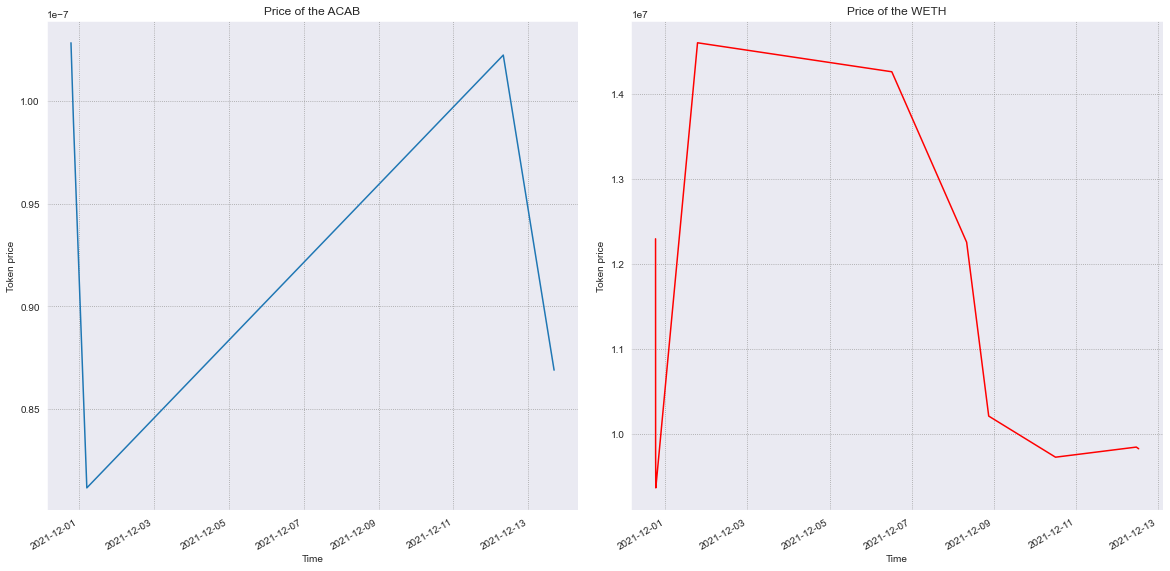

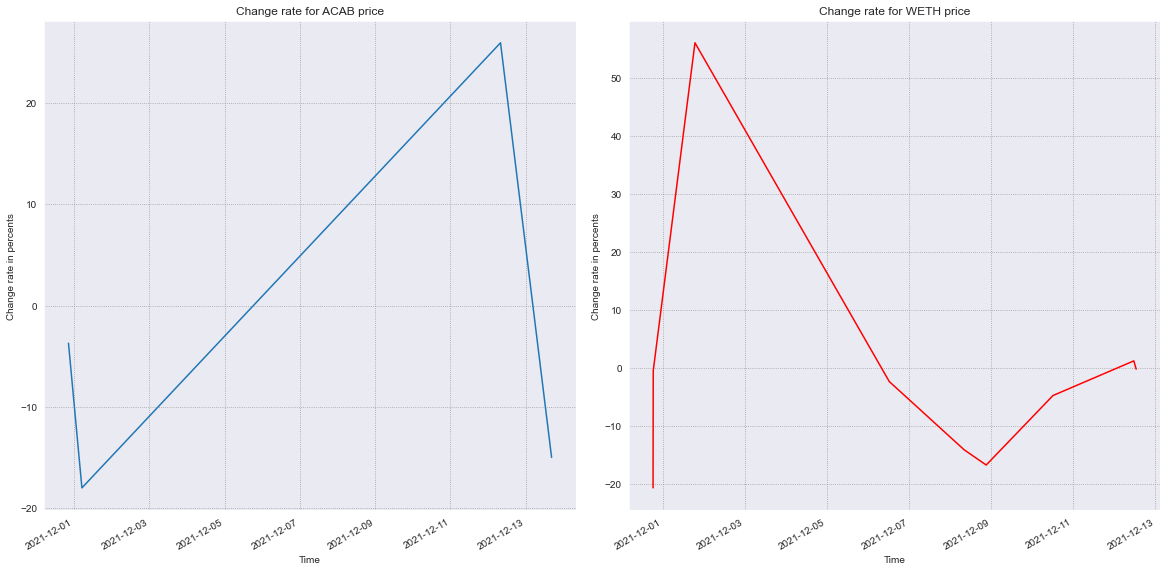

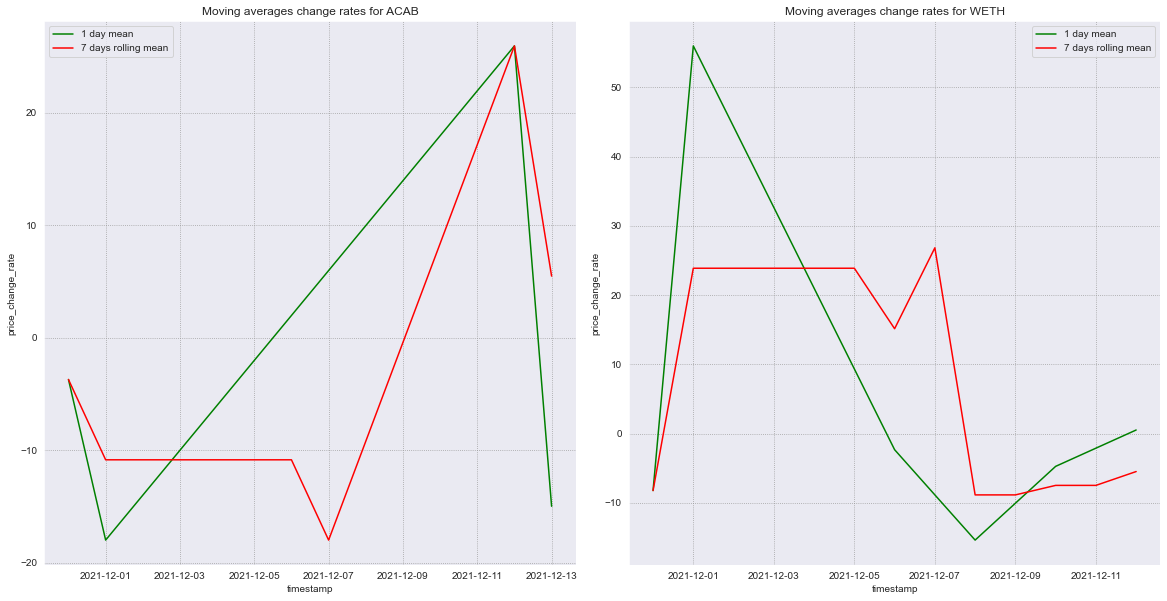

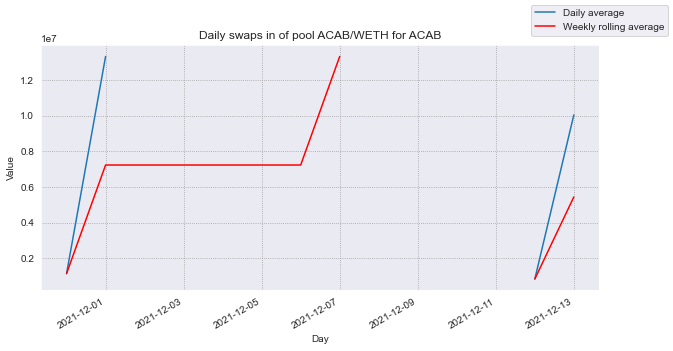

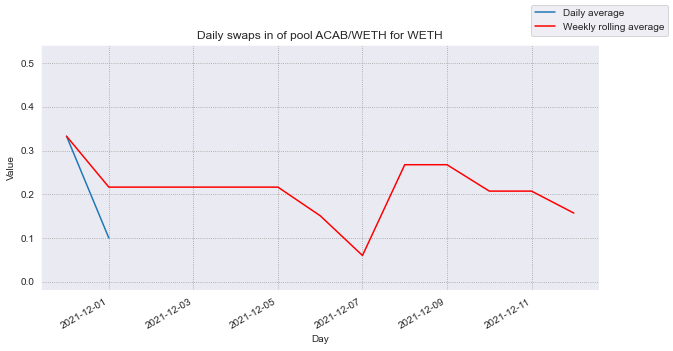

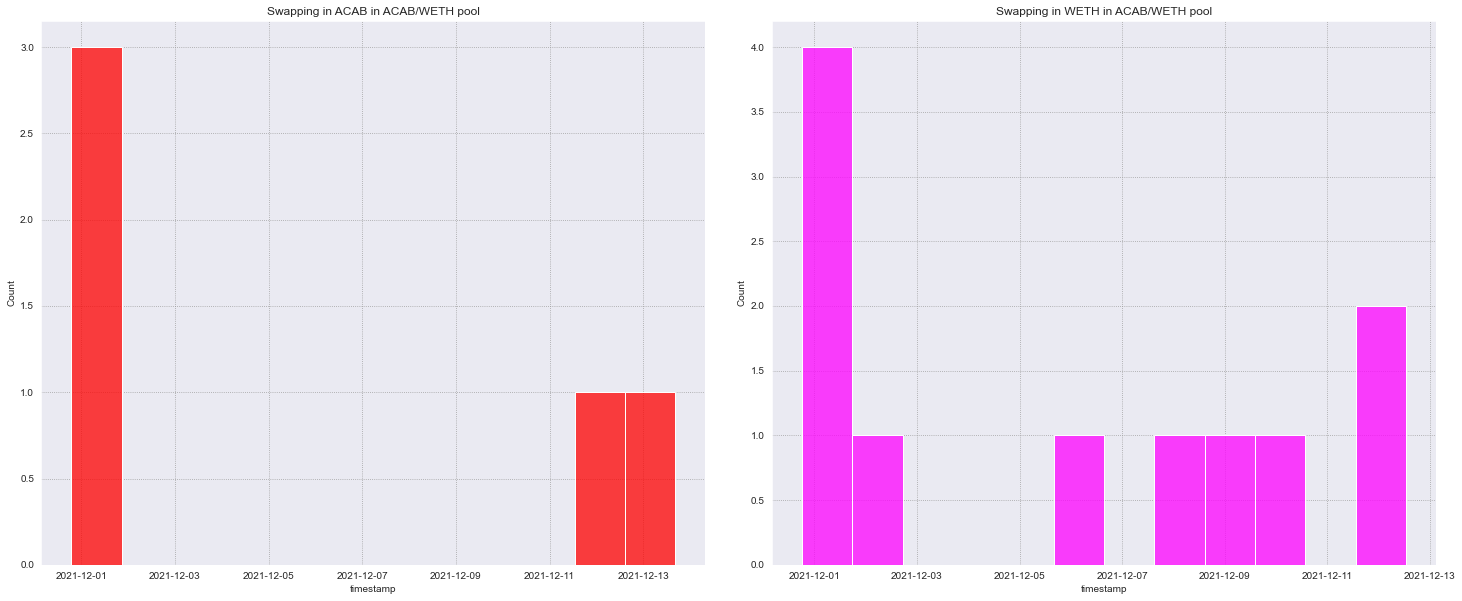

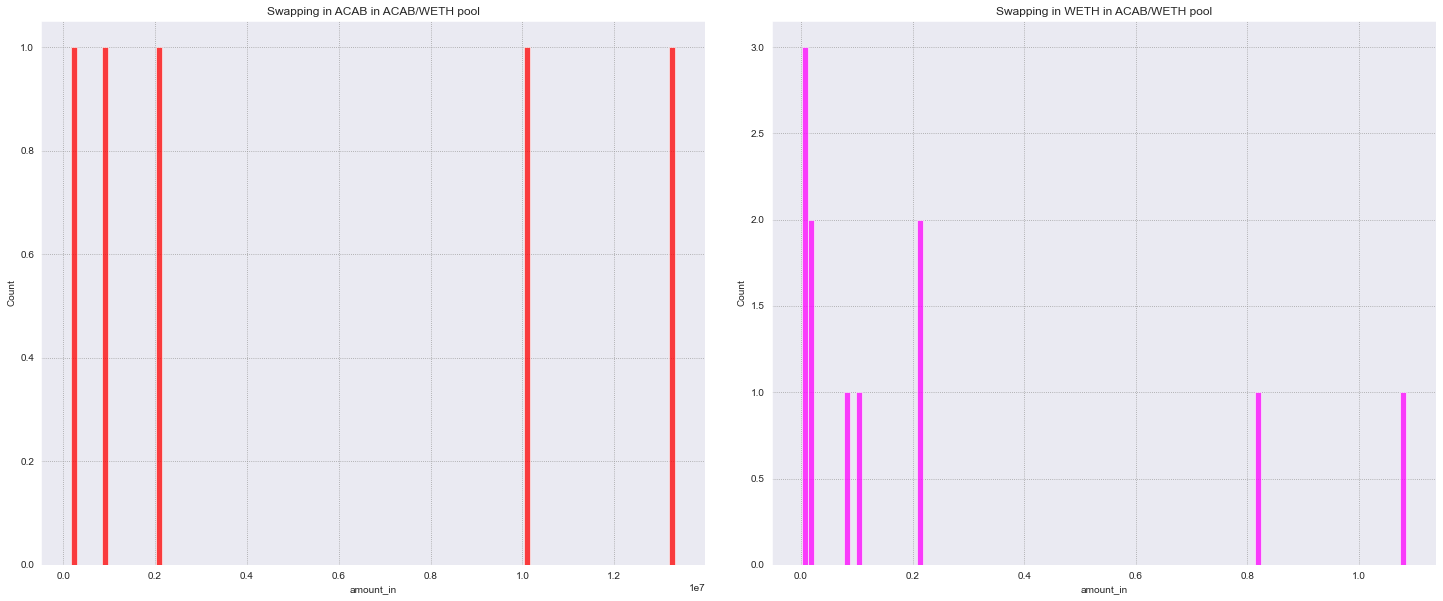

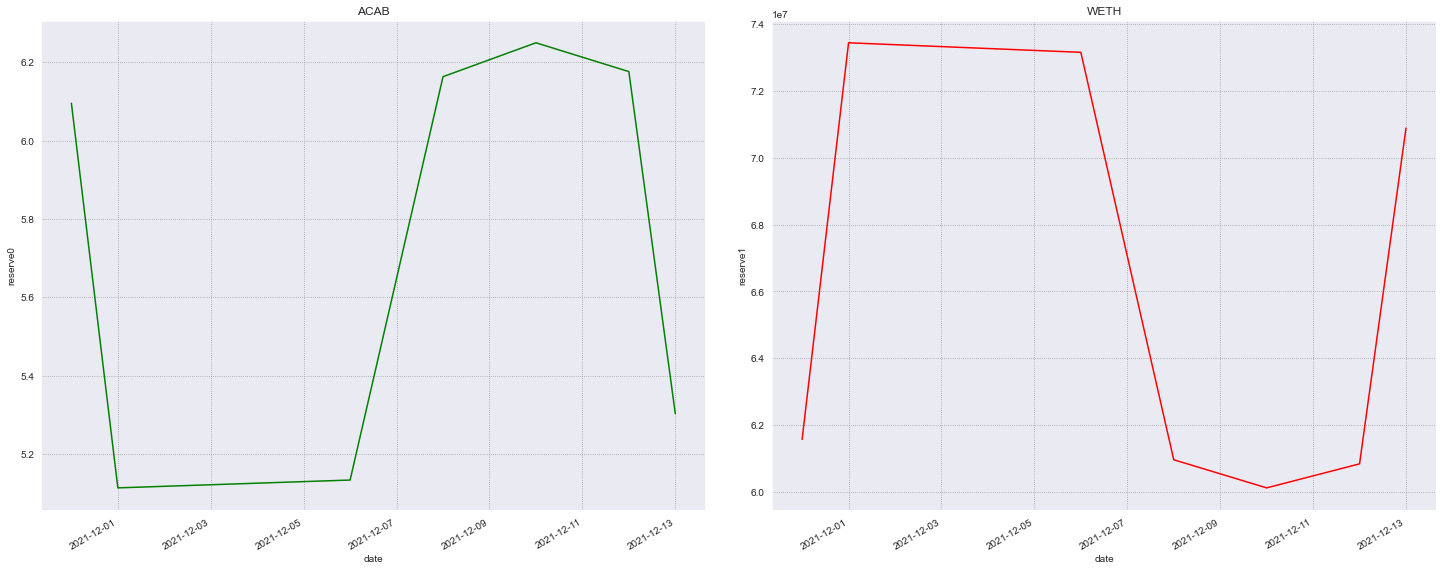

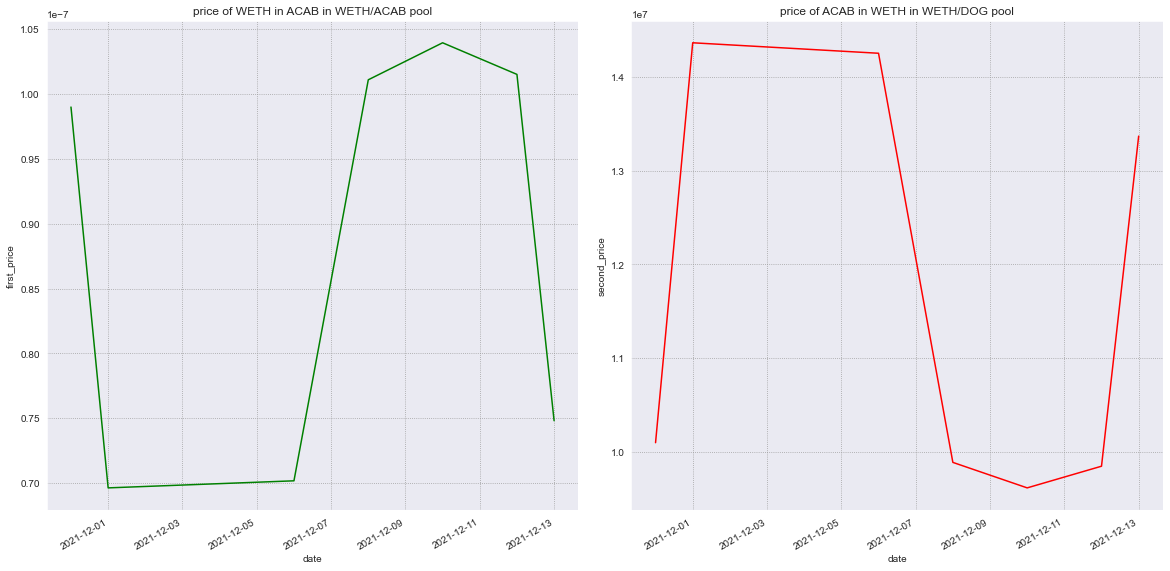

In [37]:
acab_weth_df = get_df_with_swap_prices_and_change_rates(acab_weth_df, 'ACAB', 'WETH')

pyplot_line_swap_prices(acab_weth_df, 'ACAB', 'WETH', xsize=20, ysize=10, wspace=0.1, hspace=0.1)

pyplot_line_swap_change_rate(acab_weth_df, 'ACAB', 'WETH', xsize=20, ysize=10, wspace=0.1, hspace=0.1)

swaps_price_change_rates_moving_averages(acab_weth_df, 'ACAB', 'WETH', 'Moving averages change rates for ACAB',
                                           'Moving averages change rates for WETH', x_size=20, y_size=10, wspace=0.1, hspace=0.1)

show_swaps_amount_in_moving_averages(swaps_df=acab_weth_df[(acab_weth_df.token_in == 'ACAB')], pool_name="ACAB/WETH for ACAB")
show_swaps_amount_in_moving_averages(swaps_df=acab_weth_df[(acab_weth_df.token_in == 'WETH')], pool_name="ACAB/WETH for WETH")

# swapping values histograms
plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
sns.histplot(data=acab_weth_df[acab_weth_df.token_in == 'ACAB'], x='timestamp', 
             bins=(acab_weth_df.timestamp[len(acab_weth_df) - 1] - acab_weth_df.timestamp[0]).days, 
             color='red').set_title("Swapping in ACAB in ACAB/WETH pool")
plt.subplot(1, 2, 2)
sns.histplot(data=acab_weth_df[acab_weth_df.token_in == 'WETH'], x='timestamp', 
             bins=(acab_weth_df.timestamp[len(acab_weth_df) - 1] - acab_weth_df.timestamp[0]).days, 
             color='magenta').set_title("Swapping in WETH in ACAB/WETH pool")
plt.subplots_adjust(wspace=0.1)
plt.show()

# swapping in values distribution
plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
sns.histplot(data=acab_weth_df[acab_weth_df.token_in == 'ACAB'], x='amount_in', bins=100, 
             color='red').set_title("Swapping in ACAB in ACAB/WETH pool")
plt.subplot(1, 2, 2)
sns.histplot(data=acab_weth_df[acab_weth_df.token_in == 'WETH'], x='amount_in', bins=100, 
             color='magenta').set_title("Swapping in WETH in ACAB/WETH pool")
plt.subplots_adjust(wspace=0.1)
plt.show()

show_reserves_time_distribution(acab_weth_reserves_df, first_token_reserve_name="ACAB", 
                                           second_token_reserve_name="WETH", x=25, y=10, wspace=0.1)

show_reserve_price_distributions(acab_weth_reserves_df, first_token_price_name="price of WETH in ACAB in WETH/ACAB pool", 
                                        second_token_price_name="price of ACAB in WETH in WETH/DOG pool", x=20, y=10, wspace=0.1)